In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx

import matplotlib.pyplot as plt
#import statsmodels.api as sm
import scipy

In [2]:
%matplotlib inline
plt.style.use('default')

In [3]:
data_dir = ".\\data"
img_dir = ".\\img"

output_links_lookup = os.path.join(data_dir, "pavement_links_to_or_links.csv")
output_or_roads = os.path.join(data_dir, "open_roads_clean.shp")

output_road_network = os.path.join(data_dir, "open-roads RoadLink betcen diffs")
road_nodes = os.path.join(data_dir, "open-roads RoadNode Intersect Within simplify angles.shp")
pave_nodes = os.path.join(data_dir, "pedNetworkNodes.shp")
output_pave_links = os.path.join(data_dir, "pednetworkLinksWithCentralities")
output_pave_ex_diag_links = os.path.join(data_dir, "pednetworkLinksExDiagWithCentralities")
output_pave_res_links = os.path.join(data_dir, "pednetworkLinksResWithCentralities")
output_pave_rt_links = os.path.join(data_dir, "pednetworkLinksResTimeWithCentralities")

## Load data

In [4]:
gdfRoadBC = gpd.read_file(output_road_network)
gdfRoadNodes = gpd.read_file(road_nodes)
gdfPaveBC = gpd.read_file(output_pave_links)
gdfPaveExDiagBC = gpd.read_file(output_pave_ex_diag_links)
gdfPaveResBC = gpd.read_file(output_pave_res_links)
gdfPaveRTBC = gpd.read_file(output_pave_rt_links)

gdfPaveNodes = gpd.read_file(pave_nodes)

In [89]:
gdfPaveExDiagBC.head()

MNodeFID        PNodeFID                  fid      linkType  \
0     pave_node_1     pave_node_2        pave_link_1_2  direct_cross   
1     pave_node_1  pave_node_6660     pave_link_1_6660      pavement   
2     pave_node_2  pave_node_6662     pave_link_2_6662      pavement   
3  pave_node_6660  pave_node_6662  pave_link_6660_6662  direct_cross   
4     pave_node_4     pave_node_5        pave_link_4_5  direct_cross   

     pedRLID pedRoadID     length or_link_cr     or_fid  paveExDBC    roadBC  \
0  or_link_0      None  10.938817  or_link_0  or_link_0   0.000027  0.040631   
1       None      None  27.630827       None  or_link_0   0.010175  0.040631   
2       None      None  25.955877       None  or_link_0   0.028747  0.040631   
3  or_link_0      None  10.674244  or_link_0  or_link_0   0.003333  0.040631   
4  or_link_1      None  13.039873  or_link_1  or_link_1   0.000028  0.000469   

   rdBCPaveEx  BCDiffExDi    BCDiffEx_1     paveExDBC_  roadBC_un  BCDfExDiPv  \
0         NaN         NaN           NaN     681.666667   150579.0         NaN   
1    0.020316   -0.010141 -6.734619e-08  260695.000000   150579.0   -0.009286   
2    0.020316    0.008431  5.599117e-08  736548.333333   150579.0    0.009286   
3         NaN         NaN           NaN   85406.666667   150579.0         NaN   
4         NaN         NaN           NaN     714.666667     1737.0         NaN   

                                            geometry  
0  LINESTRING (530022.591 174254.483, 530011.844 ...  
1  LINESTRING (530022.591 174254.483, 530017.186 ...  
2  LINESTRING (530011.844 174256.526, 530007.142 ...  
3  LINESTRING (530017.186 174227.386, 530007.142 ...  
4  LINESTRING (529934.847 174248.823, 529921.870 ...

In [90]:
gdfPaveBC['linkType'].value_counts()

pavement        7138
diag_cross      7103
direct_cross    5986
Name: linkType, dtype: int64

# Aggregate Centrality Comparison

## Centrality Distributions

First compare distributions of centralities between the networks and then compare the centrality values on a link by link basis using regression.

In [91]:
gdfRoadBC.head()

fid   MNodeFID      PNodeFID      length     BCSum  BCSumExDi  \
0  or_link_0  or_node_0  or_node_2558   31.757846  0.038669   0.038921   
1  or_link_1  or_node_1  or_node_2558   85.014484  0.000403   0.000410   
2  or_link_2  or_node_2  or_node_2558   28.258818  0.038934   0.039200   
3  or_link_3  or_node_0     or_node_5   80.179265  0.000714   0.000698   
4  or_link_4  or_node_3     or_node_0  104.560987  0.001560   0.001547   

   BCSumRes   BCSumRT   BCRange  BCRangeExD  BCRangeRes  BCRangeRT    roadBC  \
0  0.037901  0.037949  0.029843         NaN         NaN        NaN  0.040631   
1  0.000384  0.000380  0.000288         NaN    0.000192   0.000189  0.000469   
2  0.038151  0.038190  0.029277         NaN         NaN        NaN  0.040908   
3  0.000726  0.000730  0.000494         NaN    0.000500   0.000504  0.001000   
4  0.001572  0.001585  0.000978         NaN    0.000997   0.001010  0.001778   

   roadBC_un                                           geometry  
0   150579.0  LINESTRING (530018.000 174260.000, 530012.180 ...  
1     1737.0  LINESTRING (529929.610 174249.020, 530012.180 ...  
2   151605.0  LINESTRING (530007.000 174201.000, 530012.180 ...  
3     3707.0  LINESTRING (530018.000 174260.000, 529938.590 ...  
4     6589.0  LINESTRING (530121.000 174242.000, 530018.000 ...

C:\Anaconda3\envs\geoforge\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


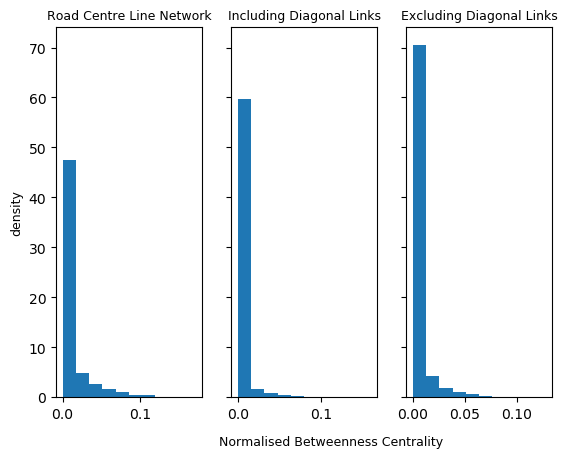

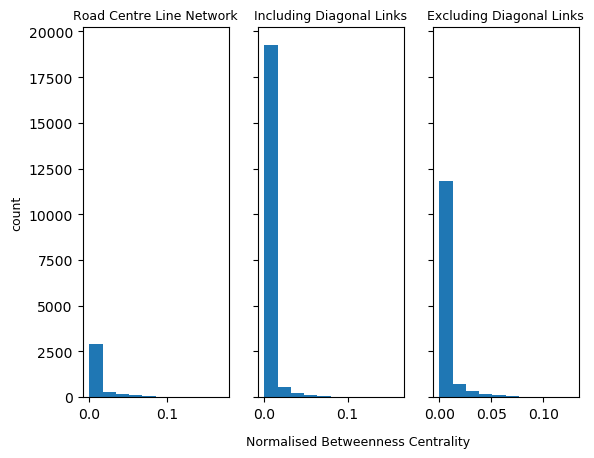

In [92]:
n_bins = 10

for label, d in [ ('density', True), ('count', False) ]:
    fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=False)

    # We can set the number of bins with the `bins` kwarg
    _ = axs[0].hist(abs(gdfRoadBC['roadBC']), bins=n_bins, density = d)
    _ = axs[1].hist(abs(gdfPaveBC['paveBC']), bins=n_bins, density = d)
    _ = axs[2].hist(abs(gdfPaveExDiagBC['paveExDBC']), bins=n_bins, density = d)

    axis_fontdict = {'fontsize':9}
    axs[0].set_ylabel(label, fontdict = axis_fontdict)
    plt.text(0.38, 0.01, "Normalised Betweenness Centrality", fontdict = axis_fontdict, transform=fig.transFigure)

    title_fontdict = {'fontsize': 9}
    axs[0].set_title("Road Centre Line Network", fontdict = title_fontdict)
    axs[1].set_title("Including Diagonal Links", fontdict = title_fontdict)
    axs[2].set_title("Excluding Diagonal Links", fontdict = title_fontdict)
    
    fig.show()

C:\Anaconda3\envs\geoforge\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


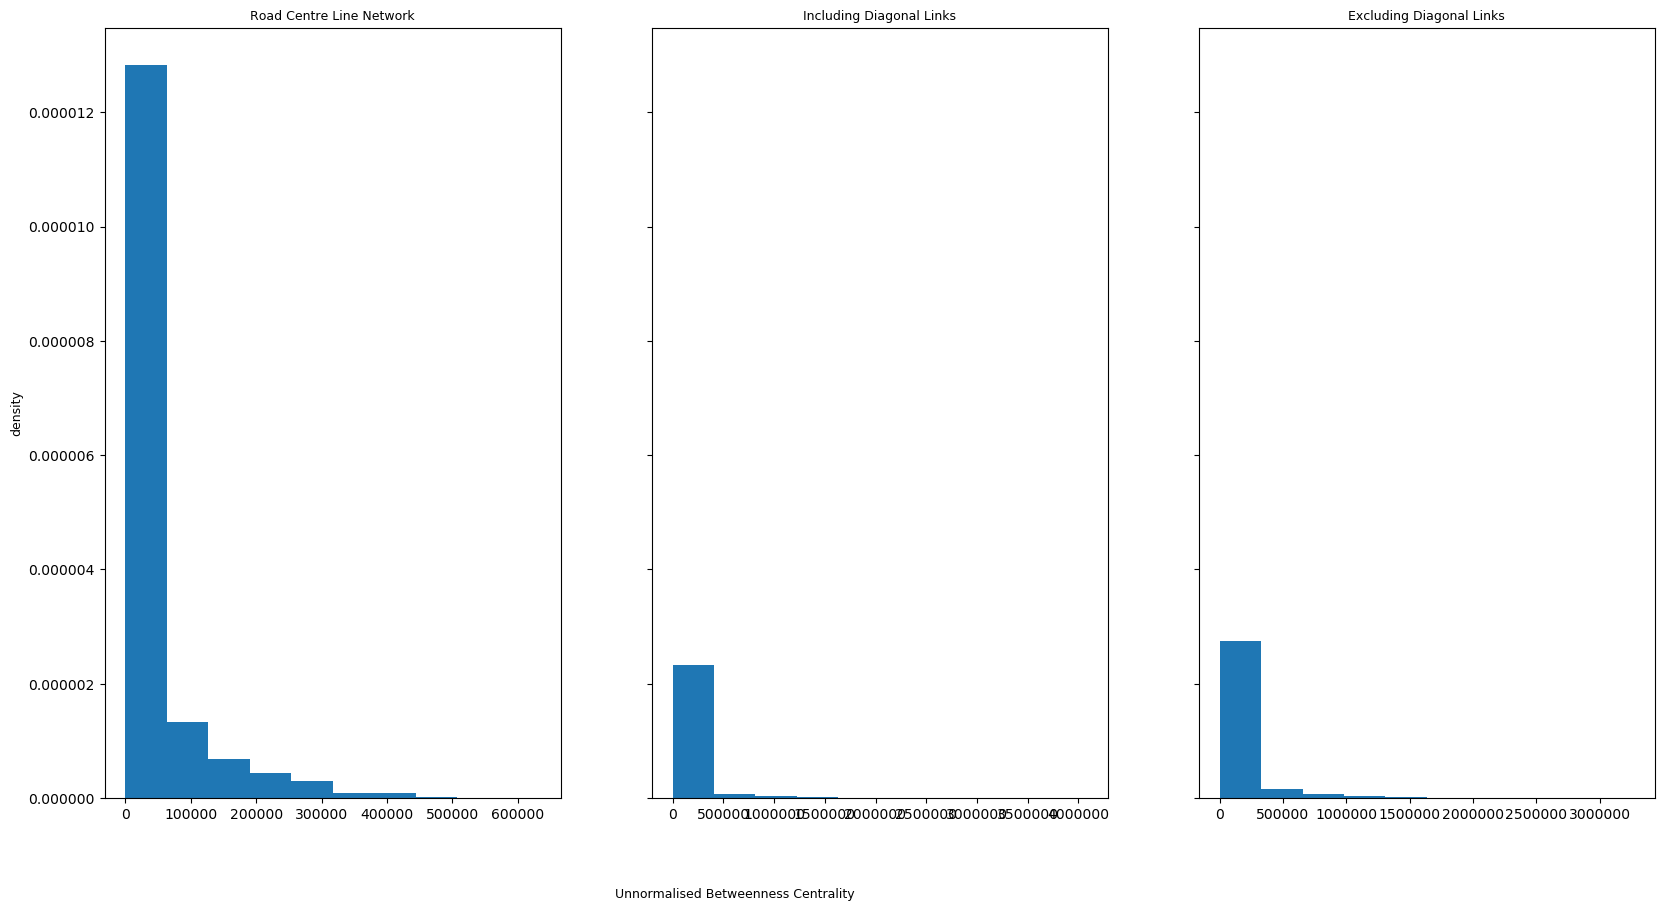

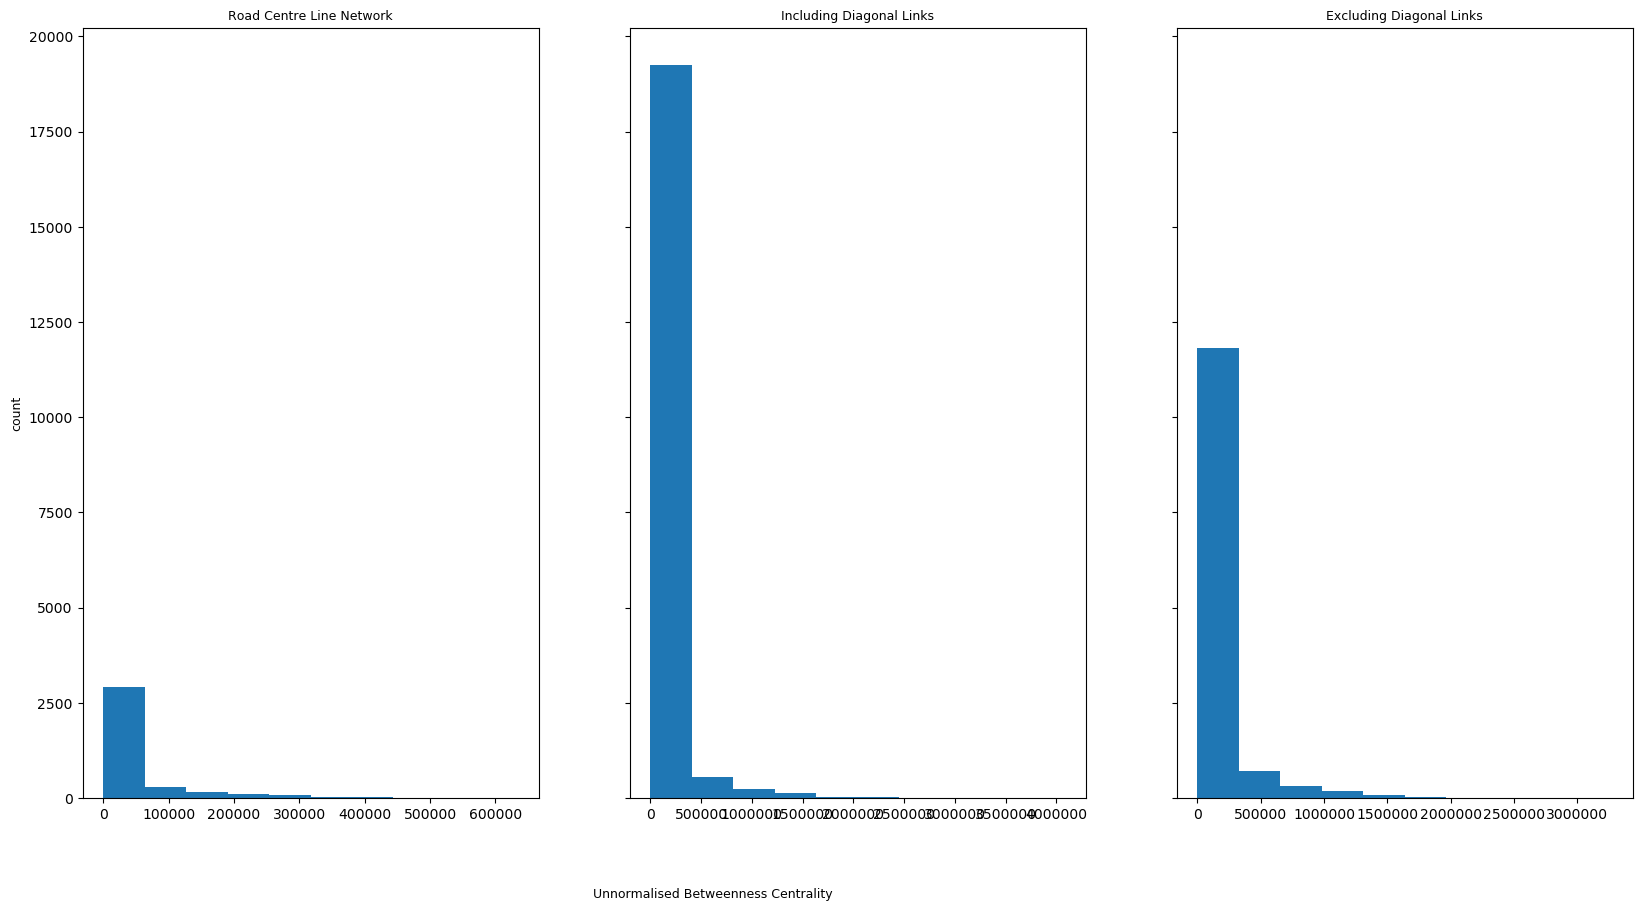

In [93]:
n_bins = 10

for label, d in [ ('density', True), ('count', False) ]:
    fig, axs = plt.subplots(1, 3, figsize=(20,10), sharey=True, tight_layout=False)

    # We can set the number of bins with the `bins` kwarg
    _ = axs[0].hist(abs(gdfRoadBC['roadBC_un']), bins=n_bins, density = d)
    _ = axs[1].hist(abs(gdfPaveBC['paveBC_un']), bins=n_bins, density = d)
    _ = axs[2].hist(abs(gdfPaveExDiagBC['paveExDBC_']), bins=n_bins, density = d)

    axis_fontdict = {'fontsize':9}
    axs[0].set_ylabel(label, fontdict = axis_fontdict)
    plt.text(0.38, 0.01, "Unnormalised Betweenness Centrality", fontdict = axis_fontdict, transform=fig.transFigure)

    title_fontdict = {'fontsize': 9}
    axs[0].set_title("Road Centre Line Network", fontdict = title_fontdict)
    axs[1].set_title("Including Diagonal Links", fontdict = title_fontdict)
    axs[2].set_title("Excluding Diagonal Links", fontdict = title_fontdict)
    
    fig.show()

Text(0.5, 1.0, 'Excluding Diagonal Links')

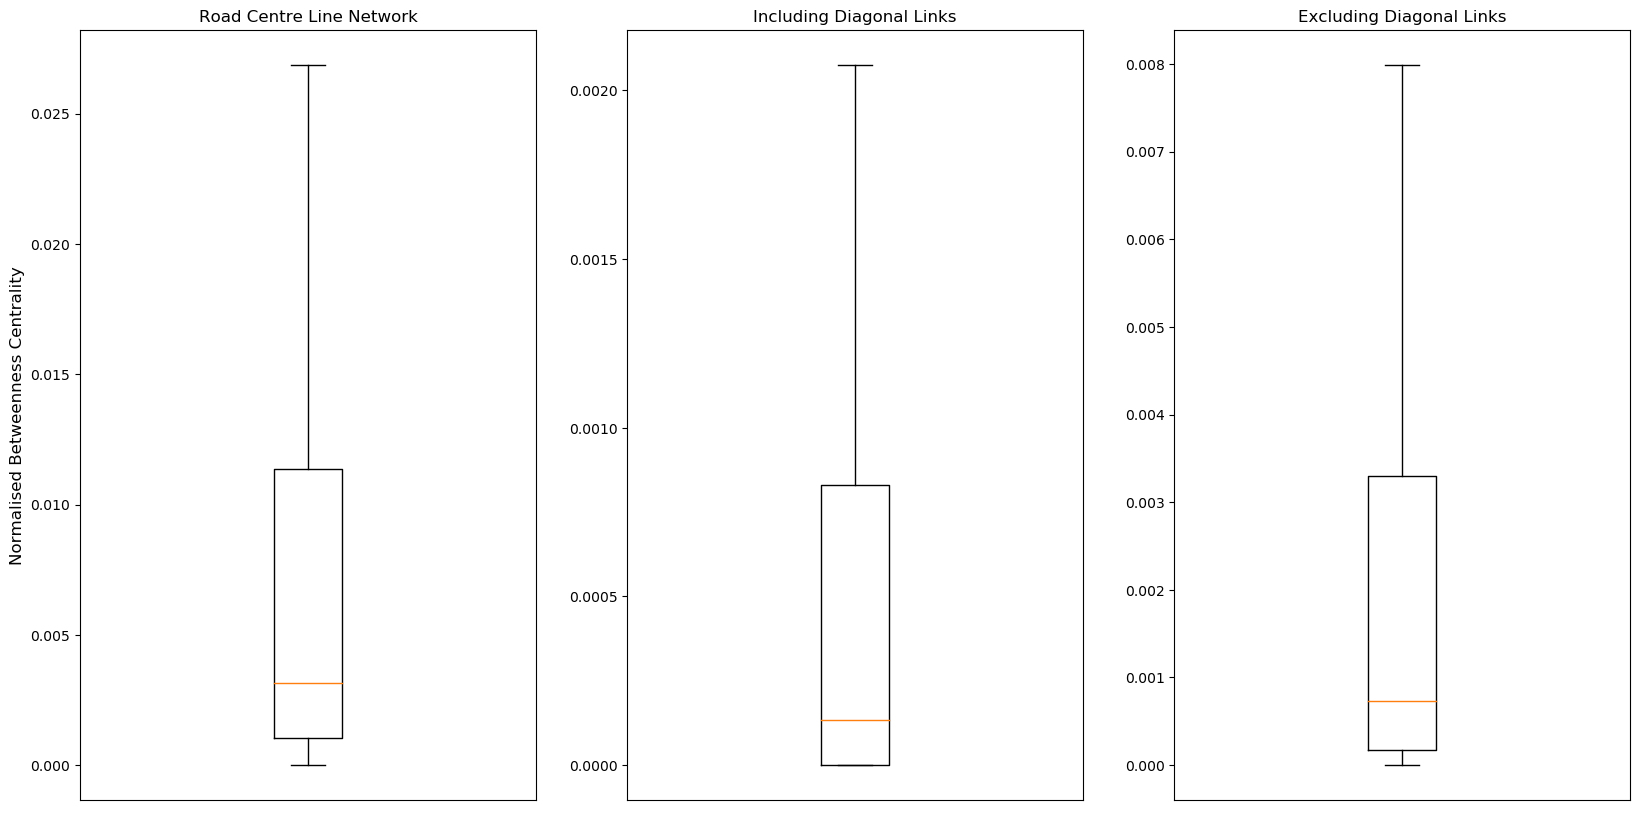

In [94]:
fig, axs = plt.subplots(1, 3, figsize = (20,10), sharey=False, tight_layout=False)

# We can set the number of bins with the `bins` kwarg
_ = axs[0].boxplot(gdfRoadBC['roadBC'].dropna(), vert=True, sym="")
_ = axs[1].boxplot(gdfPaveBC['paveBC'].dropna(), vert=True, sym="")
_ = axs[2].boxplot(gdfPaveExDiagBC['paveExDBC'].dropna(), vert=True, sym="")

axis_fontdict = {'fontsize':12}
axs[0].set_ylabel("Normalised Betweenness Centrality", fontdict = axis_fontdict)

axs[0].set(xlabel=None, xticks=[])
axs[1].set(xlabel=None, xticks=[])
axs[2].set(xlabel=None, xticks=[])

title_fontdict = {'fontsize': 12}
axs[0].set_title("Road Centre Line Network", fontdict = title_fontdict)
axs[1].set_title("Including Diagonal Links", fontdict = title_fontdict)
axs[2].set_title("Excluding Diagonal Links", fontdict = title_fontdict)

## RCL vs pavement centralities

Compare aggregated pavement network centrality values to RCL centrality values

In [95]:
data = gdfRoadBC.loc[:, ['roadBC', 'BCSum']].dropna()

regressor_OLS = sm.OLS(endog=data['roadBC'], exog=sm.add_constant(data['BCSum'])).fit()
regressor_OLS.summary()

C:\Anaconda3\envs\geoforge\lib\site-packages\numpy\core\fromnumeric.py:2608: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 roadBC   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                 9.873e+04
Date:                Fri, 09 Jul 2021   Prob (F-statistic):               0.00
Time:                        11:23:32   Log-Likelihood:                 14991.
No. Observations:                3567   AIC:                        -2.998e+04
Df Residuals:                    3565   BIC:                        -2.996e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002   7.09e-05     -2.613      0.009      -0.000   -4.63e-05
BCSum          1.0226      0.003    314.219      0.000       1.016       1.029
==============================================================================
Omnibus:                      954.095   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45558.568
Skew:                          -0.470   Prob(JB):                         0.00
Kurtosis:                      20.483   Cond. No.                         53.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Aggregated UPN betweenness centrality (normalised)')

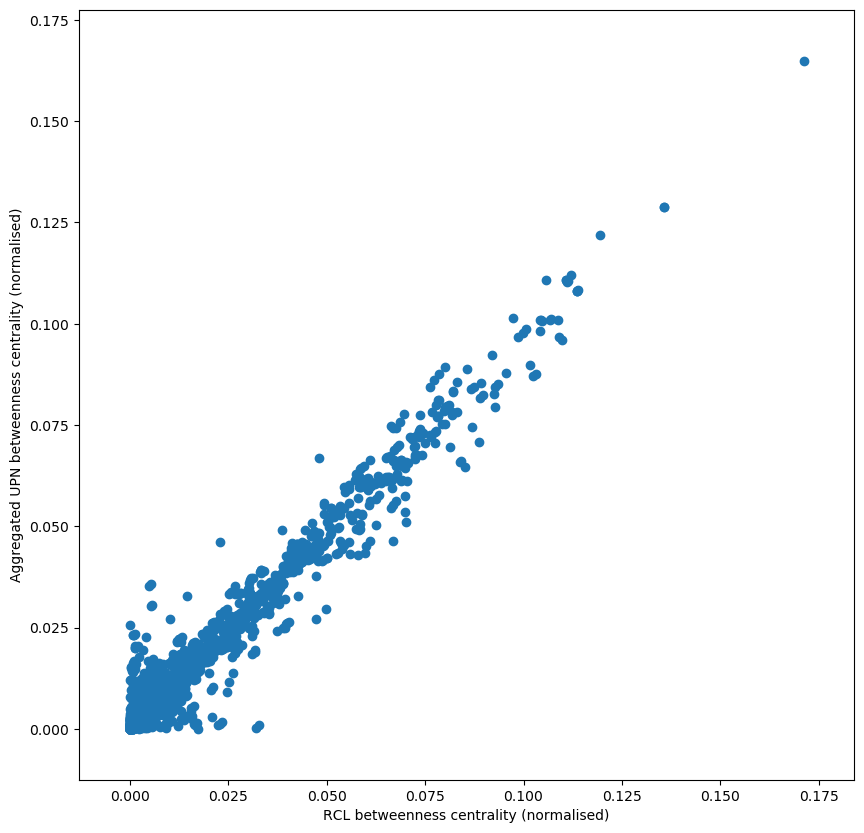

In [96]:
fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(data['roadBC'], data['BCSum'])
plt.xlabel("RCL betweenness centrality (normalised)")
plt.ylabel("Aggregated UPN betweenness centrality (normalised)")

### Repeat for pavement network excluding diagonal links

In [97]:
data = gdfRoadBC.loc[:, ['roadBC', 'BCSumExDi']].dropna()

regressor_OLS = sm.OLS(endog=data['roadBC'], exog=sm.add_constant(data['BCSumExDi'])).fit()
regressor_OLS.summary()

C:\Anaconda3\envs\geoforge\lib\site-packages\numpy\core\fromnumeric.py:2608: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 roadBC   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 2.622e+05
Date:                Fri, 09 Jul 2021   Prob (F-statistic):               0.00
Time:                        11:23:32   Log-Likelihood:                 16684.
No. Observations:                3565   AIC:                        -3.336e+04
Df Residuals:                    3563   BIC:                        -3.335e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   4.36e-05      2.611      0.009    2.83e-05       0.000
BCSumExDi      1.0140      0.002    512.026      0.000       1.010       1.018
==============================================================================
Omnibus:                     2014.151   Durbin-Watson:                   1.532
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            77193.154
Skew:                           2.054   Prob(JB):                         0.00
Kurtosis:                      25.423   Cond. No.                         52.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Differences between regression models

Model fit is higher and coefficient of pavement link centrality is higher too. This suggests that removing the diagonal links from the network makes the remaining links more closely match the road centre line centrality values.

This is unexpected sincec would have though more links would mean that the pavement network more closely matches the 'no barrier' assumption of road centre line.

However, by excluding diagonal links have reduced sample size.

Text(0, 0.5, 'Aggregated CPN betweenness centrality (normalised)')

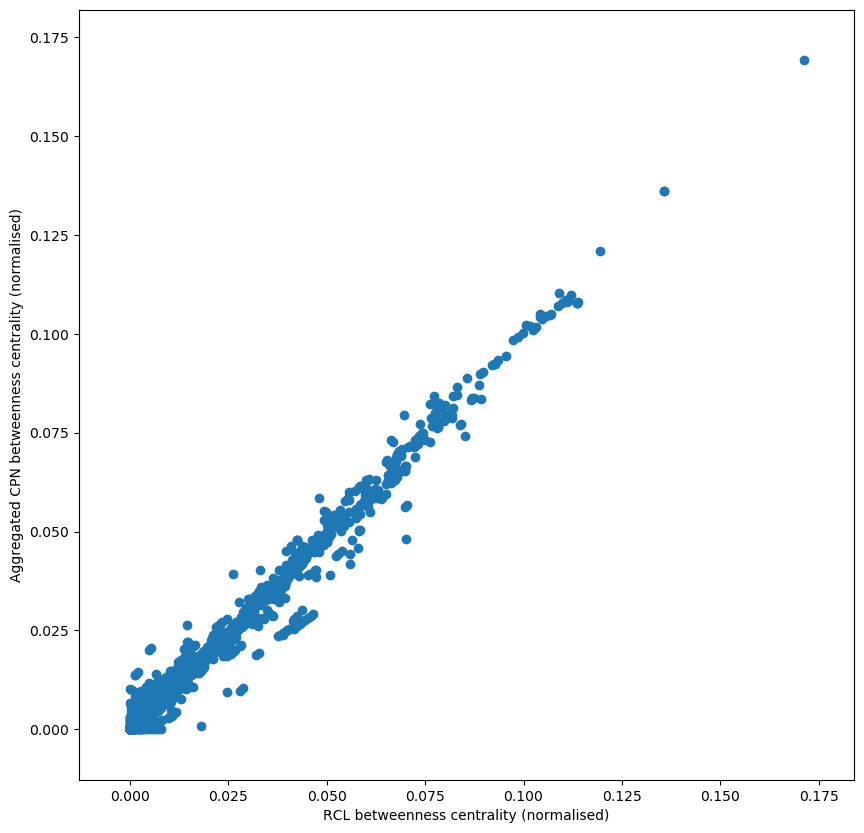

In [98]:
fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(data['roadBC'], data['BCSumExDi'])
plt.xlabel("RCL betweenness centrality (normalised)")
plt.ylabel("Aggregated CPN betweenness centrality (normalised)")

# Rank correlation

Calculate spearmans ranks correlation coefficient for the rank of road betweenness centrality and pavement betweenness centrality.

In [99]:
gdfRoadBC['roadBCRank'] = gdfRoadBC['roadBC'].rank()
gdfRoadBC['BCSumRank'] = gdfRoadBC['BCSum'].rank()
gdfRoadBC['BCSumExDiRank'] = gdfRoadBC['BCSumExDi'].rank()
gdfRoadBC['BCSumResRank'] = gdfRoadBC['BCSumRes'].rank()
gdfRoadBC['BCSumRTRank'] = gdfRoadBC['BCSumRT'].rank()

In [100]:
data = gdfRoadBC.loc[:, ['roadBCRank', 'BCSumRank']].dropna().values
scipy.stats.spearmanr(data, axis=0)

SpearmanrResult(correlation=0.9176866188309359, pvalue=0.0)

In [101]:
data = gdfRoadBC.loc[:, ['roadBCRank', 'BCSumExDiRank']].dropna().values
scipy.stats.spearmanr(data, axis=0)

SpearmanrResult(correlation=0.9586953561308468, pvalue=0.0)

In [102]:
data = gdfRoadBC.loc[:, ['roadBCRank', 'BCSumResRank']].dropna().values
scipy.stats.spearmanr(data, axis=0)

SpearmanrResult(correlation=0.920363434022655, pvalue=0.0)

In [103]:
data = gdfRoadBC.loc[:, ['roadBCRank', 'BCSumRTRank']].dropna().values
scipy.stats.spearmanr(data, axis=0)

SpearmanrResult(correlation=0.9128140734616982, pvalue=0.0)

In [104]:
(gdfRoadBC['BCSumRes'] == gdfRoadBC['BCSumRT']).value_counts()

False    3297
True      282
dtype: int64

In [105]:
# Find links where values are not the same
gdfRoadBC.loc[ gdfRoadBC['BCSumRes']!=gdfRoadBC['BCSumRT'], ['fid','or_fid','BCSumRes','BCSumRT', 'BCSum', 'BCSumExDi', 'BCSumRank']]

C:\Anaconda3\envs\geoforge\lib\site-packages\pandas\core\indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


fid  or_fid  BCSumRes   BCSumRT     BCSum  BCSumExDi  BCSumRank
0        or_link_0     NaN  0.037901  0.037949  0.038669   0.038921     3253.0
1        or_link_1     NaN  0.000384  0.000380  0.000403   0.000410      288.0
2        or_link_2     NaN  0.038151  0.038190  0.038934   0.039200     3257.0
3        or_link_3     NaN  0.000726  0.000730  0.000714   0.000698      608.0
4        or_link_4     NaN  0.001572  0.001585  0.001560   0.001547     1185.0
5        or_link_5     NaN  0.039869  0.039917  0.040571   0.040857     3271.0
6        or_link_6     NaN  0.000481  0.000485  0.000504   0.000502      376.0
7        or_link_7     NaN  0.000959  0.000970  0.000937   0.000893      798.0
8        or_link_9     NaN  0.002184  0.002138  0.002280   0.002211     1479.0
9        or_link_8     NaN  0.001167  0.001180  0.001151   0.001142      977.0
10      or_link_10     NaN  0.003197  0.003163  0.003251   0.003174     1779.0
11      or_link_11     NaN  0.000431  0.000432  0.000431   0.000390      313.0
12      or_link_29     NaN  0.026718  0.027619  0.027043   0.025347     3104.0
13      or_link_27     NaN  0.010557  0.011776  0.010551   0.005902     2589.0
14      or_link_28     NaN  0.006225  0.006351  0.006533   0.006018     2272.0
15      or_link_12     NaN  0.040235  0.040283  0.041065   0.041222     3273.0
16      or_link_13     NaN  0.000179  0.000179  0.000298   0.000181      204.0
17      or_link_41     NaN  0.000688  0.000689  0.000580   0.000682      527.0
18      or_link_43     NaN  0.000596  0.000595  0.000601   0.000593      535.0
19      or_link_14     NaN  0.008338  0.008587  0.008921   0.008241     2479.0
20      or_link_15     NaN  0.032483  0.032341  0.033177   0.033683     3195.0
21      or_link_16     NaN  0.006943  0.006926  0.007129   0.006780     2326.0
22      or_link_17     NaN  0.002461  0.002414  0.002561   0.002488     1578.0
23      or_link_21     NaN  0.011400  0.012473  0.011264   0.006740     2628.0
24      or_link_18     NaN  0.032440  0.032298  0.033131   0.033642     3194.0
25      or_link_19     NaN  0.030662  0.031692  0.031047   0.027308     3166.0
26      or_link_23     NaN  0.011683  0.012756  0.011550   0.007022     2644.0
27      or_link_20     NaN  0.019004  0.020276  0.019322   0.014352     2946.0
28      or_link_22     NaN  0.016558  0.017905  0.016892   0.011752     2870.0
29      or_link_24     NaN  0.024150  0.023799  0.024379   0.025423     3042.0
...            ...     ...       ...       ...       ...        ...        ...
3538  or_link_3533     NaN  0.002941  0.002940  0.002983   0.002921     1701.0
3539  or_link_3534     NaN  0.004714  0.004705  0.004762   0.004161     2052.0
3542  or_link_3538     NaN  0.002270  0.002269  0.002306   0.002271     1487.0
3543  or_link_3541     NaN  0.003185  0.003186  0.003000   0.003336     1707.0
3544  or_link_3539     NaN  0.003246  0.003237  0.003285   0.002730     1788.0
3546  or_link_3576     NaN  0.000427  0.000426  0.000414   0.000370      297.0
3547  or_link_3577     NaN  0.003075  0.003076  0.002884   0.003173     1670.0
3548  or_link_3542     NaN  0.003277  0.003286  0.003332   0.003370     1801.0
3549  or_link_3543     NaN  0.001785  0.001784  0.001814   0.001831     1290.0
3550  or_link_3545     NaN  0.000476  0.000472  0.000481   0.000526      354.0
3551  or_link_3547     NaN  0.000513  0.000514  0.000517   0.000551      389.0
3552  or_link_3546     NaN  0.000106  0.000112  0.000106   0.000056      104.0
3553  or_link_3548     NaN  0.001811  0.001808  0.001825   0.001898     1296.0
3554  or_link_3549     NaN  0.000656  0.000661  0.000659   0.000605      578.0
3555  or_link_3550     NaN  0.000042  0.000041  0.000042   0.000003       74.0
3556  or_link_3551     NaN  0.001521  0.001525  0.001530   0.001431     1175.0
3557  or_link_3553     NaN  0.002897  0.002901  0.002915   0.002807     1679.0
3559  or_link_3554     NaN  0.000465  0.000461  0.000470   0.000519      344.0
3560  or_link_3555     NaN  0.003094  0.003086  0.003117   0.0032

In [106]:
gdfRoadBC['BCSum'].isnull().value_counts()

False    3567
True       12
Name: BCSum, dtype: int64

### Explaining difference between case with diagonal links and case without

When diagonal links not included in the network, meaning that crossings between sides of the road must occur at junctions, higher correlation between road link centrality and pavement link centrality is observed.

This suggests that a pavement network representation that restricts pedestrian crossings to junctions more closely matches a road centre line representation. Diagonal links traverse space differently to pavement links that run approximately parallel to the road centre line. This difference produces betweenness centrality values that are less well correlated with road link centralities.

Does this mean that a pavement network representation would produce different flows on road links?

The rank correlation coefficient confirms the regression analysis results above. When diagonal links are excluded the centrality of the pavement network links more closely matches the centrality of the road network links.

However, the correlation is high in both cases, suggesting that were pedestrians to follow desire line more frequently flows predicted by betweenness centrality would differ only slightly.

## Explaining difference between distributions

Does the difference between aggregated centrality and RCL centrality correlate with centrality?

In [107]:
gdfRoadBC['aggBCDiff'] = abs(gdfRoadBC['roadBC'] - gdfRoadBC['BCSum'])

data = gdfRoadBC.reindex(columns = ['roadBC', 'aggBCDiff']).dropna()

regressor_OLS = sm.OLS(endog=data['aggBCDiff'], exog=sm.add_constant(data['roadBC'])).fit()
regressor_OLS.summary()

C:\Anaconda3\envs\geoforge\lib\site-packages\numpy\core\fromnumeric.py:2608: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              aggBCDiff   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     533.0
Date:                Fri, 09 Jul 2021   Prob (F-statistic):          5.00e-110
Time:                        11:24:34   Log-Likelihood:                 15679.
No. Observations:                3567   AIC:                        -3.135e+04
Df Residuals:                    3565   BIC:                        -3.134e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011   5.79e-05     18.450      0.000       0.001       0.001
roadBC         0.0595      0.003     23.087      0.000       0.054       0.065
==============================================================================
Omnibus:                     3104.920   Durbin-Watson:                   1.273
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            96278.375
Skew:                           4.124   Prob(JB):                         0.00
Kurtosis:                      27.078   Cond. No.                         51.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [108]:
gdfRoadBC['aggBCDiffExDi'] = abs(gdfRoadBC['roadBC'] - gdfRoadBC['BCSumExDi'])

data = gdfRoadBC.reindex(columns = ['roadBC', 'aggBCDiffExDi']).dropna()

regressor_OLS = sm.OLS(endog=data['aggBCDiffExDi'], exog=sm.add_constant(data['roadBC'])).fit()
regressor_OLS.summary()

C:\Anaconda3\envs\geoforge\lib\site-packages\numpy\core\fromnumeric.py:2608: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          aggBCDiffExDi   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     571.1
Date:                Fri, 09 Jul 2021   Prob (F-statistic):          3.38e-117
Time:                        11:24:34   Log-Likelihood:                 17340.
No. Observations:                3565   AIC:                        -3.468e+04
Df Residuals:                    3563   BIC:                        -3.466e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006   3.63e-05     17.296      0.000       0.001       0.001
roadBC         0.0386      0.002     23.898      0.000       0.035       0.042
==============================================================================
Omnibus:                     3339.064   Durbin-Watson:                   1.143
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           133850.636
Skew:                           4.529   Prob(JB):                         0.00
Kurtosis:                      31.619   Cond. No.                         51.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The regresstion shows that RCL link centrality is correlated with the difference between aggregated centrality and RCL centrality. This means that one of the assumptions of the regression analysis is violated since errors are not independent.

Also suggests that for more central links, the difference between the pavement network centrality and RCL centrality is greater. This is interesting as it potentially increases the significant of the simplifying RCL assumption. 

However, this dependence could also be caused by the approximate normalisations which perhaps has more of an effect on high centrality links (this would make sense since high centrality links have more paths passing through them, therefore greater need for proper normalisation).

# Disaggregate Centrality Comparison

In this section of analysis I compare the pavement link cecntrality values to the disaggregated RCL centrality values.

## Pavement centrality range

First, look at the distribution of the range of pavement link centrality values

In [109]:
gdfRoadBC.columns

Index(['fid', 'MNodeFID', 'PNodeFID', 'length', 'BCSum', 'BCSumExDi',
       'BCSumRes', 'BCSumRT', 'BCRange', 'BCRangeExD', 'BCRangeRes',
       'BCRangeRT', 'roadBC', 'roadBC_un', 'geometry', 'roadBCRank',
       'BCSumRank', 'BCSumExDiRank', 'BCSumResRank', 'BCSumRTRank',
       'aggBCDiff', 'aggBCDiffExDi'],
      dtype='object')

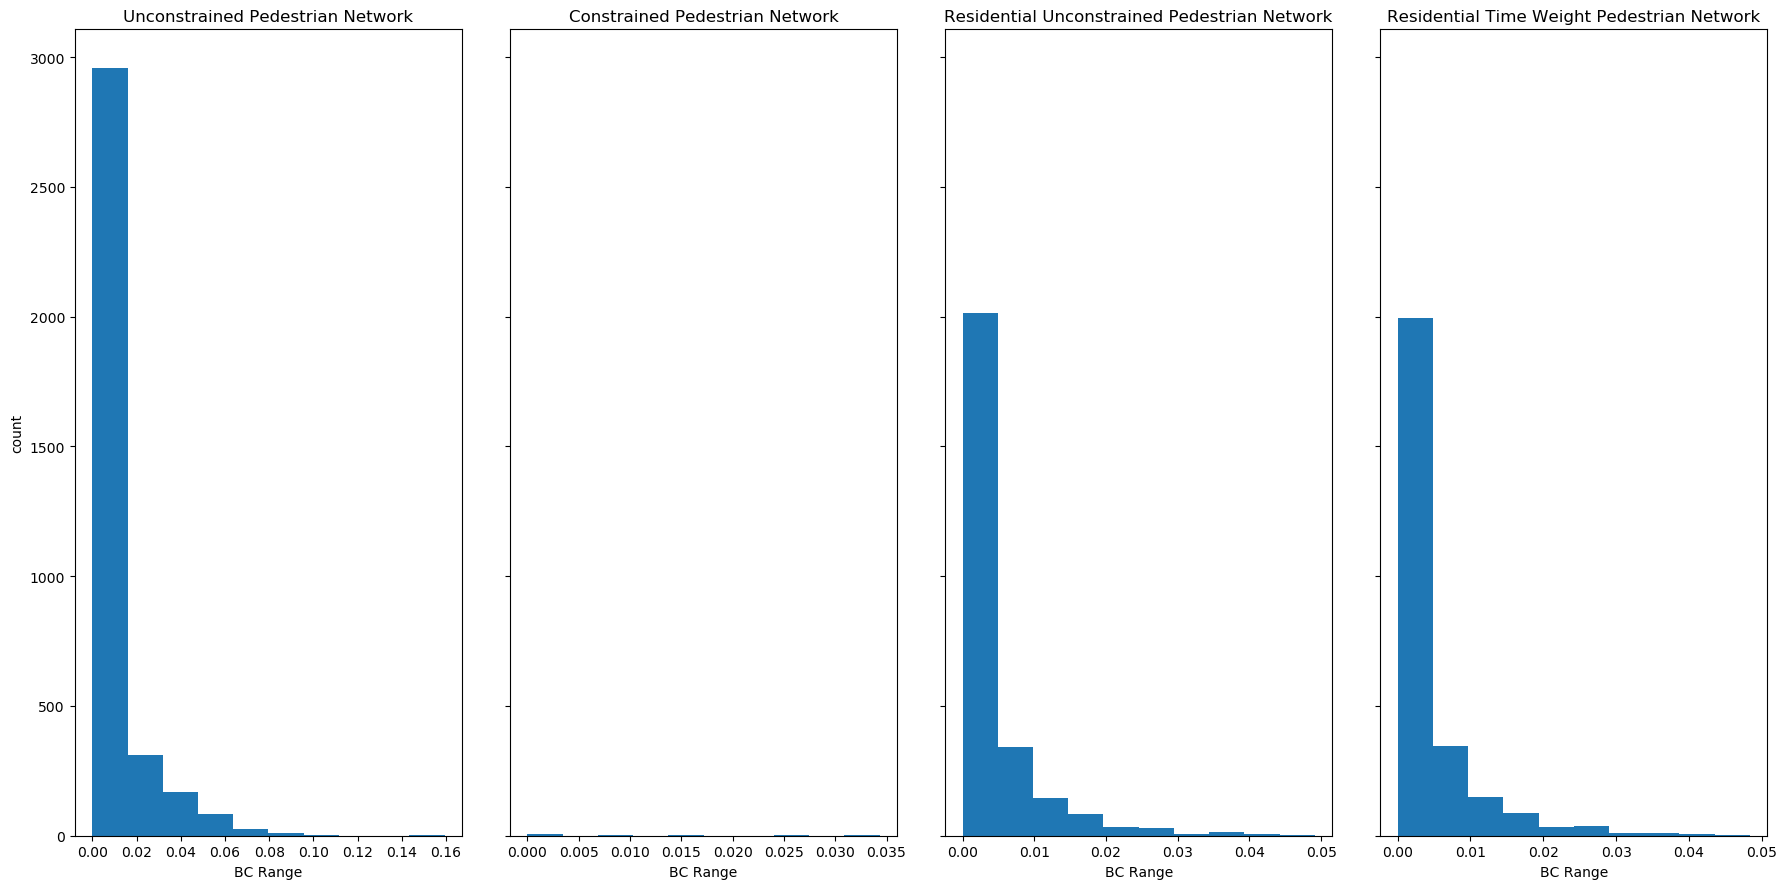

In [110]:
n_bins = 10
fig, axs = plt.subplots(1, 4, figsize = (18,9), sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
_ = axs[0].hist(gdfRoadBC['BCRange'].dropna(), bins=n_bins)
_ = axs[1].hist(gdfRoadBC['BCRangeExD'].dropna(), bins=n_bins)
_ = axs[2].hist(gdfRoadBC['BCRangeRes'].dropna(), bins=n_bins)
_ = axs[3].hist(gdfRoadBC['BCRangeRT'].dropna(), bins=n_bins)

axs[0].set_ylabel("count")
axs[0].set_xlabel("BC Range")
axs[1].set_xlabel("BC Range")
axs[2].set_xlabel("BC Range")
axs[3].set_xlabel("BC Range")

titles = [  "Unconstrained Pedestrian Network",
            "Constrained Pedestrian Network",
            "Residential Unconstrained Pedestrian Network",
            "Residential Time Weight Pedestrian Network"
         ]
for i, title in enumerate(titles):
    axs[i].set_title(title)

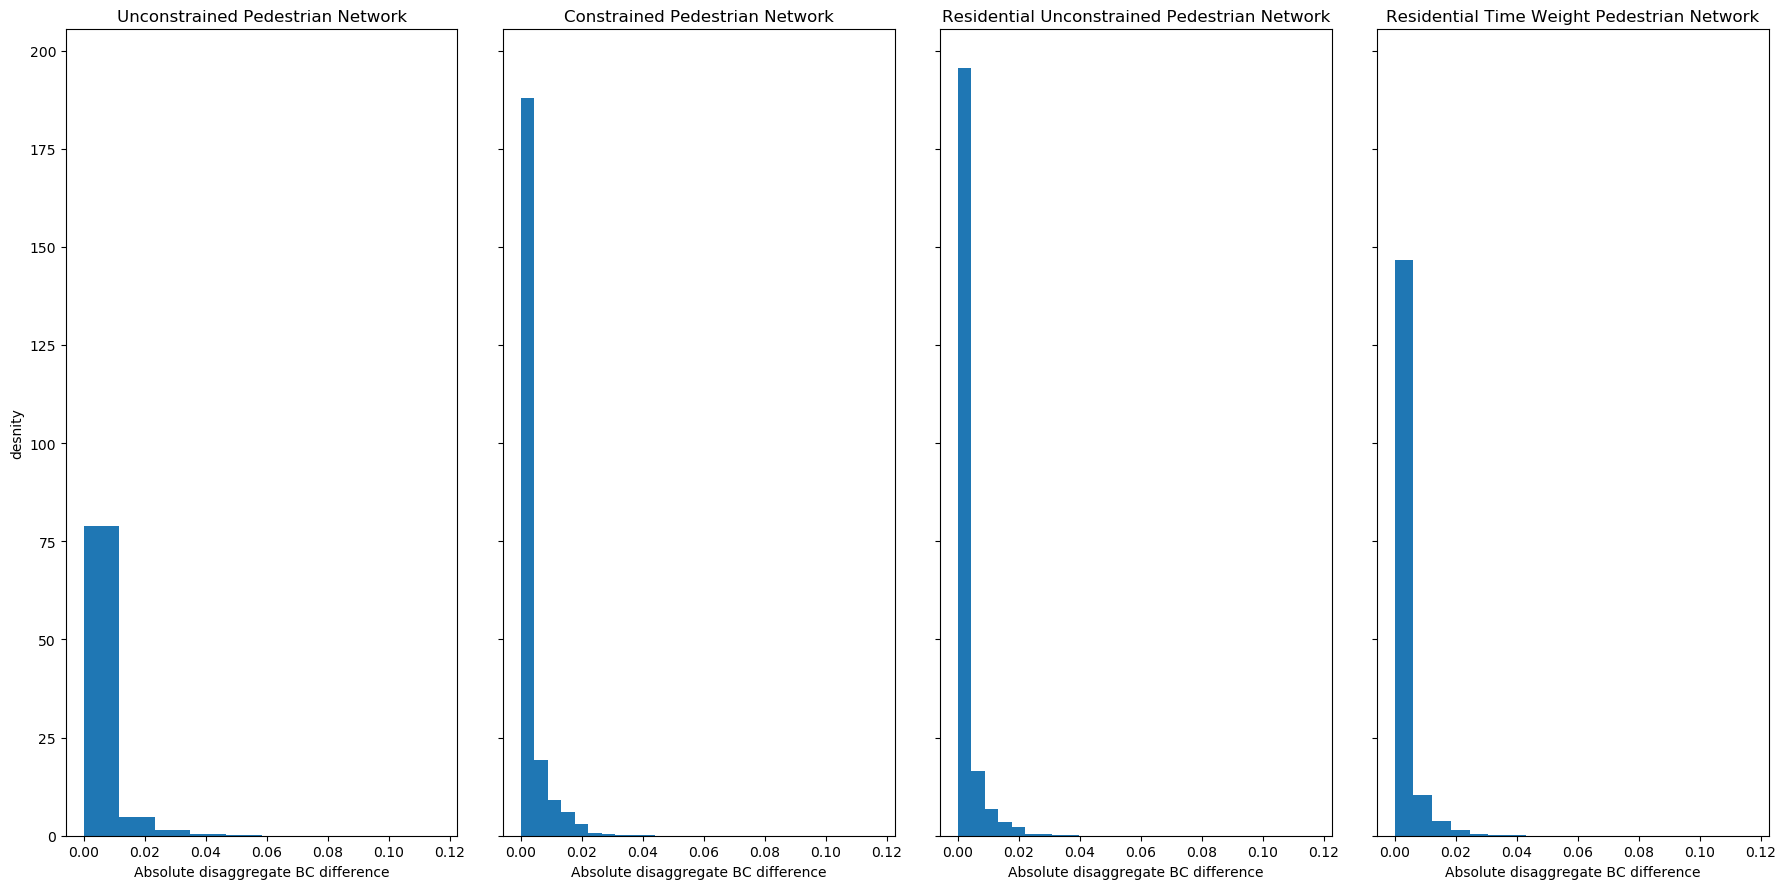

In [111]:
n_bins = 10
fig, axs = plt.subplots(1, 4, figsize = (18,9), sharey=True, sharex=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
_ = axs[0].hist(abs(gdfPaveBC['BCDiff']), bins=n_bins, density=True)
_ = axs[1].hist(abs(gdfPaveExDiagBC['BCDiffExDi']), bins=n_bins, density=True)
_ = axs[2].hist(abs(gdfPaveResBC['BCDiffRes']), bins=n_bins, density=True)
_ = axs[3].hist(abs(gdfPaveRTBC['BCDiffRT']), bins=n_bins, density=True)

axs[0].set_ylabel("desnity")
for ax in axs:
    ax.set_xlabel("Absolute disaggregate BC difference")

for i, title in enumerate(titles):
    axs[i].set_title(title)

## Explaining difference between distributions

A pavement network representation that includes diagonal crossing links produces greater frequency of high betweenness centrality difference between non-crossing pavement links.

By providing an alternative way to move along a road link diagonal links seems to increase the centrality of one side of the road. Certain sides of the road are more frequently included in shortest routes when that side of the road is more easily accessed.

this suggests that the barrier effect plays a role in equalising pedestrian flows on either side of the road. Where the barrier effect is reduced and cariiadgeway space shared between pedestrian and vehicular modes we can expect to see increased pedestrian flow differentials on either side of the road.

## Regression - road link centrality vs difference between disaggregate centrality

### Full pavement network

In [112]:
gdfPaveBC.columns

Index(['MNodeFID', 'PNodeFID', 'fid', 'linkType', 'pedRLID', 'pedRoadID',
       'length', 'or_link_cr', 'or_fid', 'paveBC', 'roadBC', 'rdBCPave',
       'BCDiff', 'BCDiffFr', 'paveBC_un', 'roadBC_un', 'BCDiffPv', 'geometry'],
      dtype='object')

In [113]:
data = gdfPaveBC.reindex(columns = ['roadBC', 'BCDiff']).dropna()

regressor_OLS = sm.OLS(endog=abs(data['BCDiff']), exog=sm.add_constant(data['roadBC'])).fit()
regressor_OLS.summary()

C:\Anaconda3\envs\geoforge\lib\site-packages\numpy\core\fromnumeric.py:2608: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BCDiff   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                 2.590e+04
Date:                Fri, 09 Jul 2021   Prob (F-statistic):               0.00
Time:                        11:24:38   Log-Likelihood:                 58809.
No. Observations:               14241   AIC:                        -1.176e+05
Df Residuals:                   14239   BIC:                        -1.176e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002   3.78e-05      4.901      0.000       0.000       0.000
roadBC         0.2710      0.002    160.946      0.000       0.268       0.274
==============================================================================
Omnibus:                    11407.919   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           728115.027
Skew:                           3.379   Prob(JB):                         0.00
Kurtosis:                      37.372   Cond. No.                         51.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Difference between disaggregate centrality')

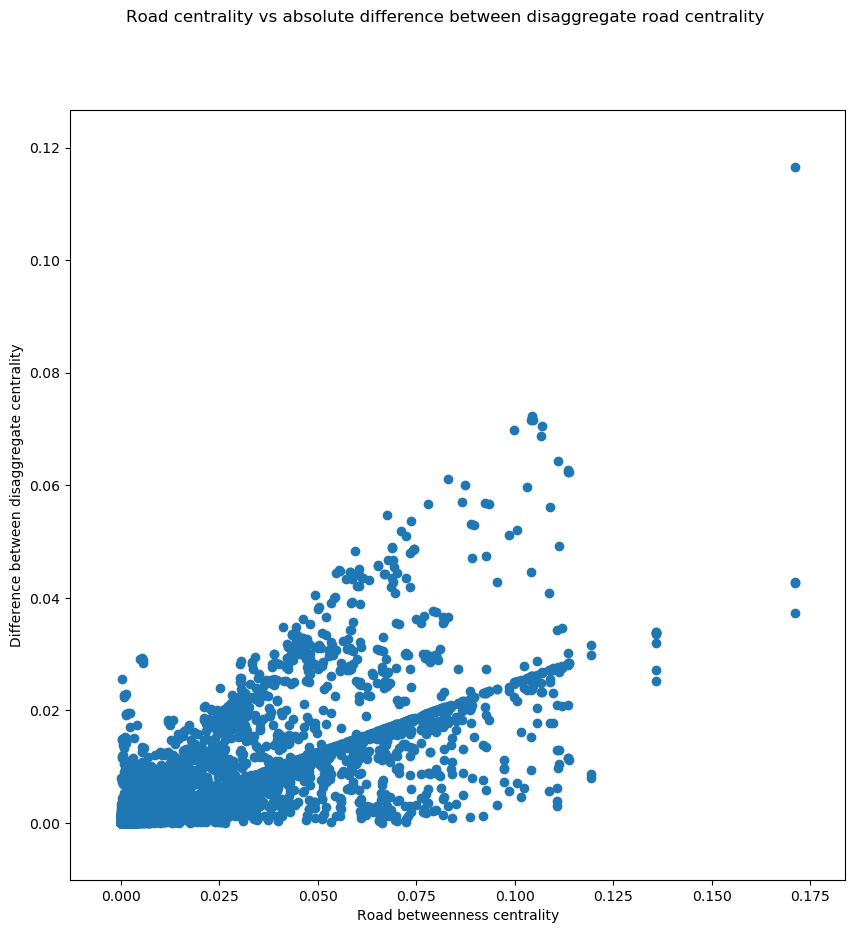

In [114]:
fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(data['roadBC'], abs(data['BCDiff']))
fig.suptitle( "Road centrality vs absolute difference between disaggregate road centrality")
plt.xlabel("Road betweenness centrality")
plt.ylabel("Difference between disaggregate centrality")

### Excluding diagonal links

Regression model fit is worse

In [115]:
gdfPaveExDiagBC.columns

Index(['MNodeFID', 'PNodeFID', 'fid', 'linkType', 'pedRLID', 'pedRoadID',
       'length', 'or_link_cr', 'or_fid', 'paveExDBC', 'roadBC', 'rdBCPaveEx',
       'BCDiffExDi', 'BCDiffEx_1', 'paveExDBC_', 'roadBC_un', 'BCDfExDiPv',
       'geometry'],
      dtype='object')

In [116]:
data = gdfPaveExDiagBC.reindex(columns = ['roadBC', 'BCDiffExDi']).dropna()

regressor_OLS = sm.OLS(endog=abs(data['BCDiffExDi']), exog=sm.add_constant(data['roadBC'])).fit()
regressor_OLS.summary()

C:\Anaconda3\envs\geoforge\lib\site-packages\numpy\core\fromnumeric.py:2608: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             BCDiffExDi   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     9556.
Date:                Fri, 09 Jul 2021   Prob (F-statistic):               0.00
Time:                        11:24:39   Log-Likelihood:                 31620.
No. Observations:                7138   AIC:                        -6.324e+04
Df Residuals:                    7136   BIC:                        -6.322e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006   3.96e-05     14.280      0.000       0.000       0.001
roadBC         0.1722      0.002     97.757      0.000       0.169       0.176
==============================================================================
Omnibus:                     1679.002   Durbin-Watson:                   1.098
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34406.262
Skew:                           0.612   Prob(JB):                         0.00
Kurtosis:                      13.686   Cond. No.                         51.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Difference between disaggregate centrality')

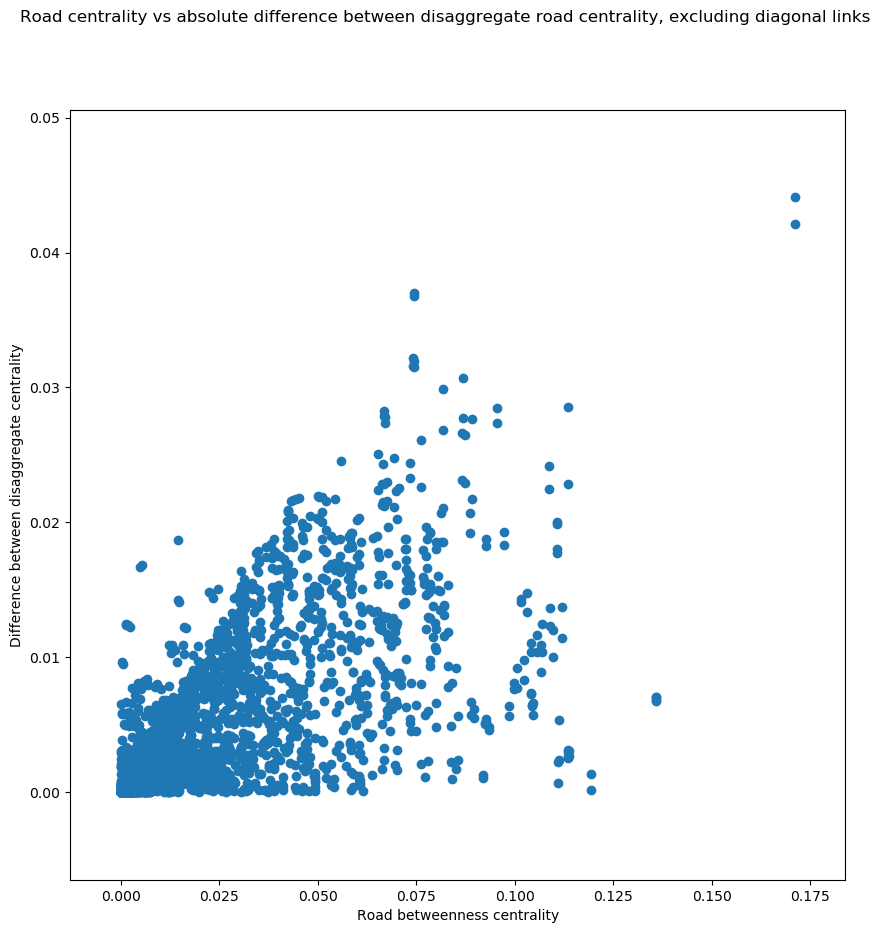

In [117]:
fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(data['roadBC'], abs(data['BCDiffExDi']))
fig.suptitle( "Road centrality vs absolute difference between disaggregate road centrality, excluding diagonal links")
plt.xlabel("Road betweenness centrality")
plt.ylabel("Difference between disaggregate centrality")

## Visualise dissagregate difference on road network

Next compare the the pavement link centrality values to the disaggregated RCL values

In [118]:
gdfPaveBC.columns

Index(['MNodeFID', 'PNodeFID', 'fid', 'linkType', 'pedRLID', 'pedRoadID',
       'length', 'or_link_cr', 'or_fid', 'paveBC', 'roadBC', 'rdBCPave',
       'BCDiff', 'BCDiffFr', 'paveBC_un', 'roadBC_un', 'BCDiffPv', 'geometry'],
      dtype='object')

## Draw network

In [19]:
gdfRoadBC.columns

Index(['fid', 'MNodeFID', 'PNodeFID', 'length', 'BCSum', 'BCSumExDi',
       'BCSumRes', 'BCSumRT', 'BCRange', 'BCRangeExD', 'BCRangeRes',
       'BCRangeRT', 'roadBC', 'roadBC_un', 'geometry'],
      dtype='object')

In [20]:
def road_network_figure(G, dict_node_pos, dict_edge_values, title, cmap_name = 'viridis', edge_width = 3, edge_alpha = 1):

    plt.style.use('dark_background')
    f, ax = plt.subplots(1,1,figsize = (15,15))

    ax = road_network_subfigure(ax, G, dict_node_pos, dict_edge_values, title, cmap_name = cmap_name, edge_width=edge_width, edge_alpha=edge_alpha)
    return f

def road_network_subfigure(ax, G, dict_node_pos, title, edge_color = 'red', edge_cmap = 'bwr', edge_width = 3, edge_alpha = 1, title_font = {'size': 12}, edge_vmin = 0, edge_vmax=1):

    nx.draw_networkx_nodes(G, dict_node_pos, ax = ax, nodelist=G.nodes(), node_color = 'grey', node_size = 1, alpha = 0.2)
    nx.draw_networkx_edges(G, dict_node_pos, ax = ax, edgelist=G.edges(), width = 3, edge_color = edge_color, edge_cmap=edge_cmap, alpha=edge_alpha, edge_vmin = edge_vmin, edge_vmax=edge_vmax)
    ax.set_title(title, fontdict = title_font, y = 0)
    ax.axis('off')
    return ax

In [21]:
# Using the geographical coordinates of the nodes when plotting them
points_pos = gdfPaveNodes.set_index('fid')
points_pos['x'] = points_pos['geometry'].map(lambda g: g.coords[0][0])
points_pos['y'] = points_pos['geometry'].map(lambda g: g.coords[0][1])
node_posistions = list(zip(points_pos['x'], points_pos['y']))
dict_node_pos = dict(zip(points_pos.index, node_posistions))

In [22]:
# Get networkx graph
G_BCDiff = nx.Graph()
edges = gdfPaveBC.loc[:, ['MNodeFID', 'PNodeFID', 'BCDiff']].dropna().values
G_BCDiff.add_weighted_edges_from(edges, weight = 'BCDiff')

G_BCDiffExDi = nx.Graph()
edges = gdfPaveExDiagBC.loc[:, ['MNodeFID', 'PNodeFID', 'BCDiffExDi']].dropna().values
G_BCDiffExDi.add_weighted_edges_from(edges, weight = 'BCDiffExDi')

G_BCDiffRes = nx.Graph()
edges = gdfPaveResBC.loc[:, ['MNodeFID', 'PNodeFID', 'BCDiffRes']].dropna().values
G_BCDiffRes.add_weighted_edges_from(edges, weight = 'BCDiffRes')

G_BCDiffRT = nx.Graph()
edges = gdfPaveRTBC.loc[:, ['MNodeFID', 'PNodeFID', 'BCDiffRT']].dropna().values
G_BCDiffRT.add_weighted_edges_from(edges, weight = 'BCDiffRT')

Draw these sections of the network

In [23]:
# get edge data to color edges by
bcdiff_data = np.array([d[-1] for d in  G_BCDiff.edges.data('BCDiff', default=0)])
bcdiff_exdi_data = np.array([d[-1] for d in G_BCDiffExDi.edges.data('BCDiffExDi', default=0)])
bcdiff_res_data = np.array([d[-1] for d in G_BCDiffRes.edges.data('BCDiffRes', default=0)])
bcdiff_rt_data = np.array([d[-1] for d in G_BCDiffRT.edges.data('BCDiffRT', default=0)])

all_values = np.concatenate([bcdiff_data, bcdiff_exdi_data])
vmin = -1*max(abs(all_values))
vmax = max(abs(all_values))

NameError: name 'fig' is not defined

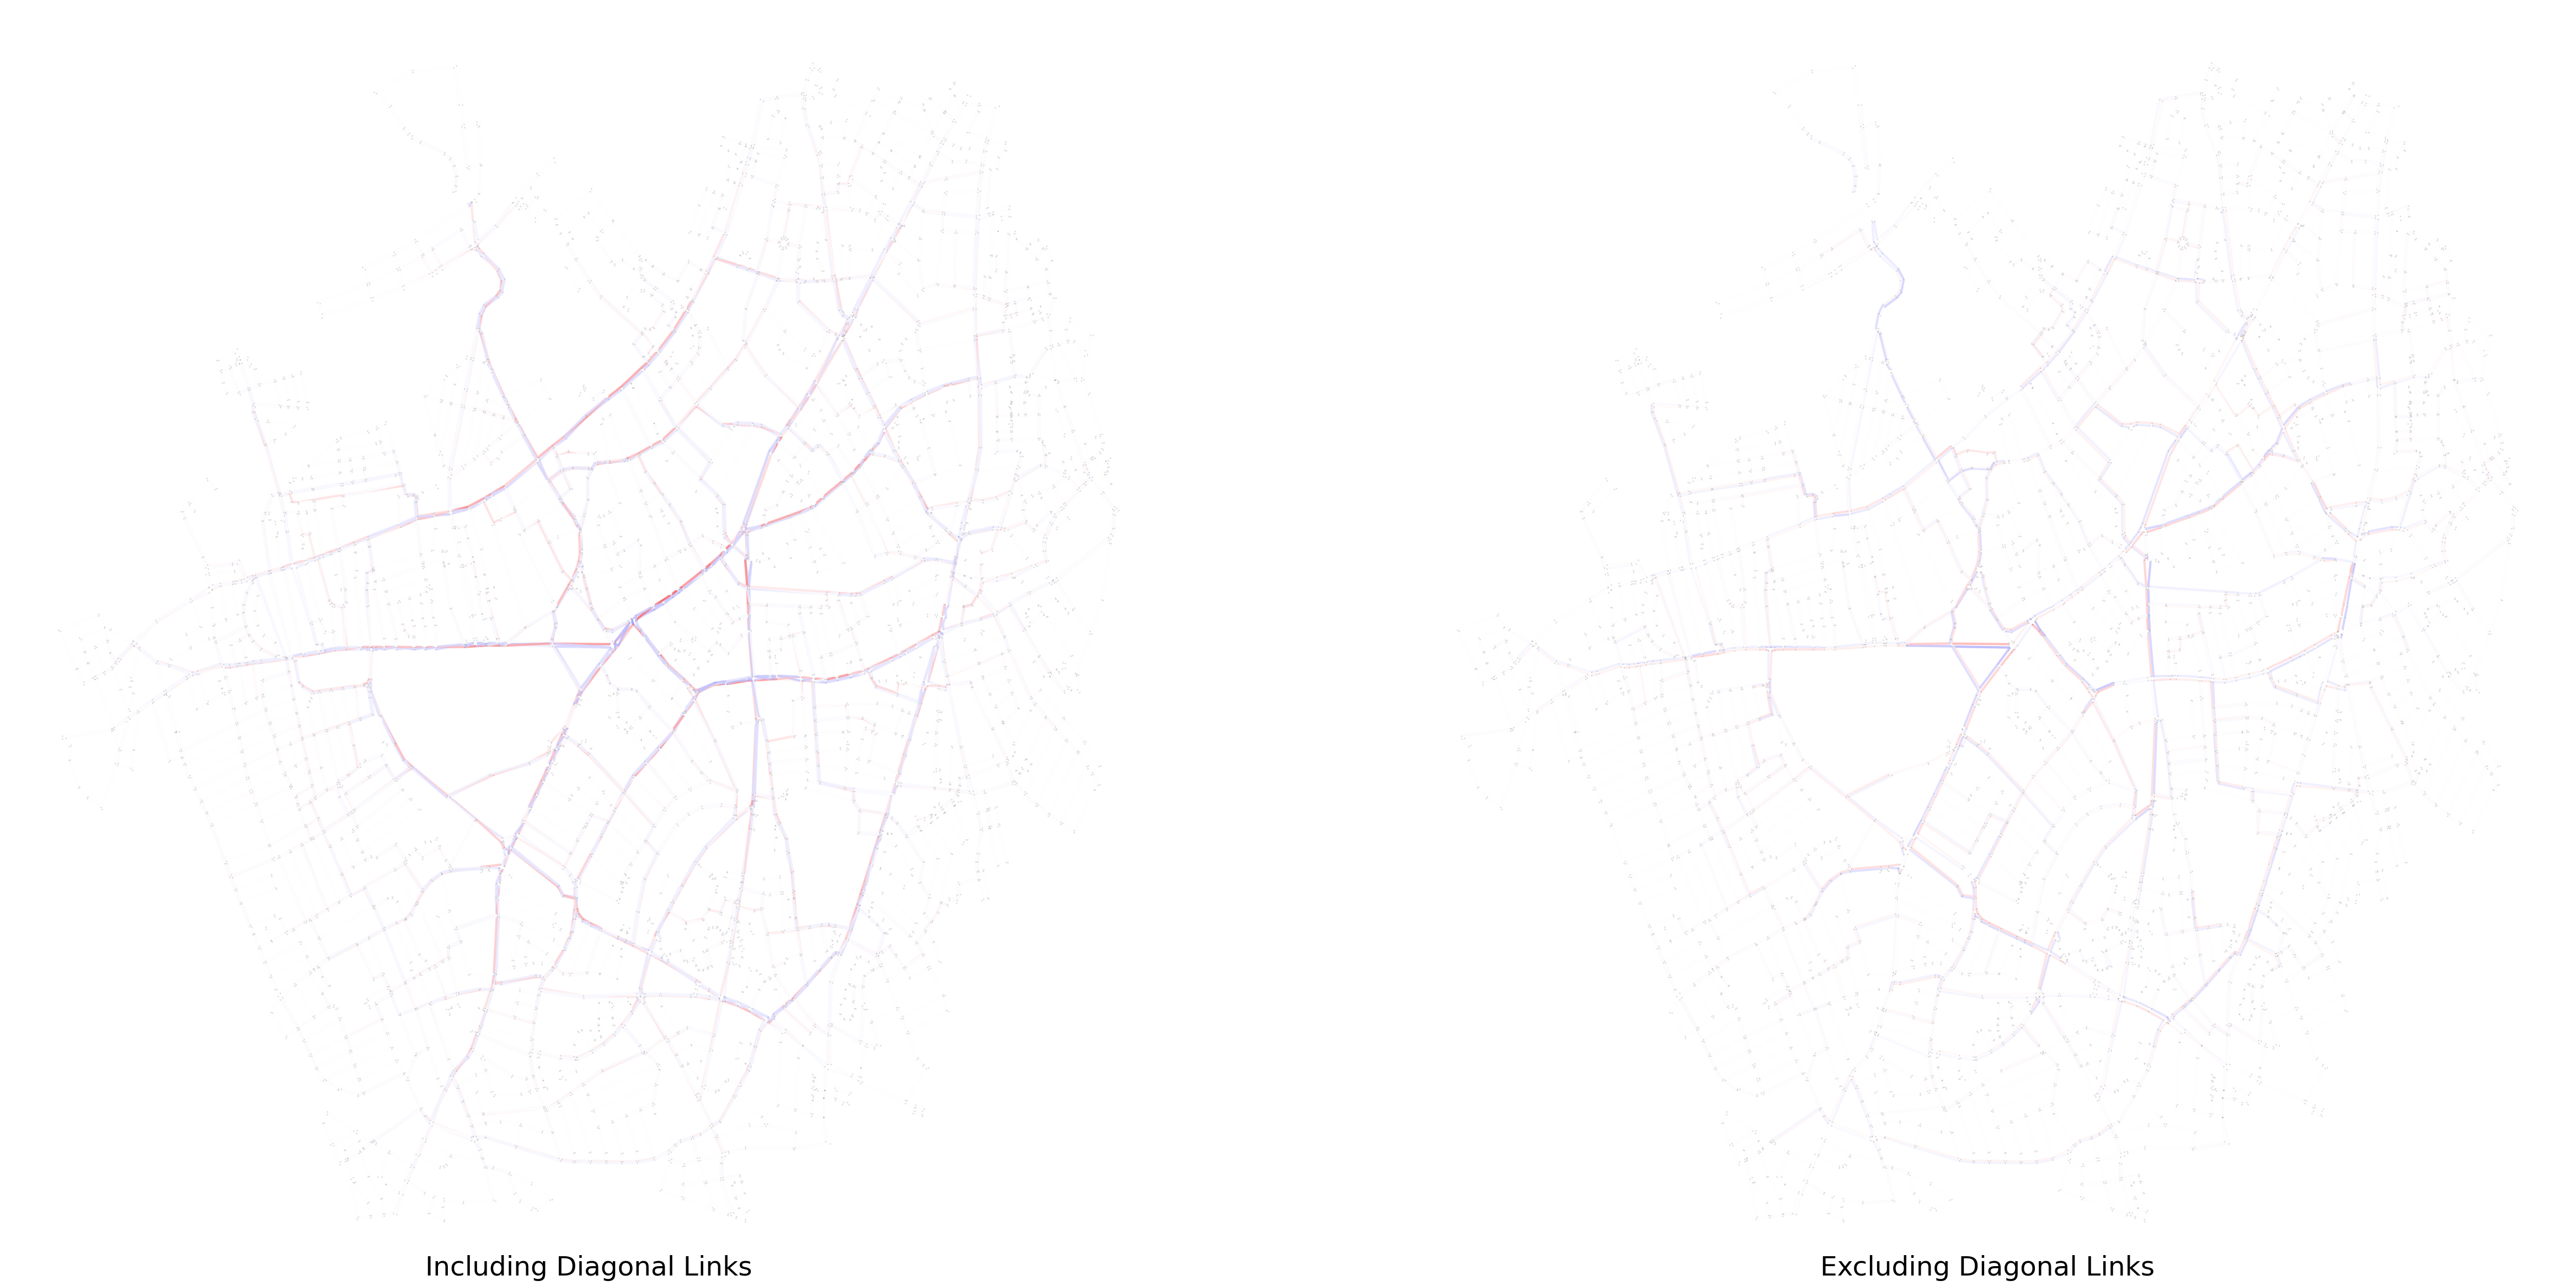

In [24]:
plt.style.use('default')


f, axs = plt.subplots(1, 2, figsize = (60,30), sharey=False, sharex=False)
        
road_network_subfigure(axs[0], G_BCDiff, dict_node_pos, "Including Diagonal Links", edge_color = bcdiff_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = 0.8, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)
road_network_subfigure(axs[1], G_BCDiffExDi, dict_node_pos, "Excluding Diagonal Links", edge_color = bcdiff_exdi_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = 0.8, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)

# Add colourbars
smap = plt.cm.ScalarMappable(cmap="bwr", norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(smap, ax=axs, fraction=0.1, shrink = 0.8)
cbar.ax.tick_params(labelsize=25)

# Just a single colour bar might be better, requires using same vmin and vmax for both network drawings.

_ = f.suptitle("Difference between pavement link centrality and disaggregated RCL centrality", y = 0.95, fontsize=48, weight = 'bold')

### Using difference values calculated using average of pavement link centralities

In [ ]:
n_bins = 10
fig, axs = plt.subplots(1, 4, figsize = (18,9), sharey=True, sharex=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
_ = axs[0].hist(abs(gdfPaveBC['BCDiffPv']), bins=n_bins, density=True)
_ = axs[1].hist(abs(gdfPaveExDiagBC['BCDfExDiPv']), bins=n_bins, density=True)
_ = axs[2].hist(abs(gdfPaveResBC['BCDfResPv']), bins=n_bins, density=True)
_ = axs[3].hist(abs(gdfPaveRTBC['BCDfRTPv']), bins=n_bins, density=True)

axs[0].set_ylabel("desnity")
for ax in axs:
    ax.set_xlabel("Absolute disaggregate BC difference")

titles = [  "Unconstrained Pedestrian Network",
            "Constrained Pedestrian Network",
            "Residential Unconstrained Pedestrian Network",
            "Residential Time Weight Pedestrian Network"
         ]
    
for i, title in enumerate(titles):
    axs[i].set_title(title)

In [ ]:
from scipy import stats

In [ ]:
# Comparing means

# Assuming from imdependent samples
scipy.stats.ttest_ind(gdfPaveExDiagBC['BCDfExDiPv'].dropna(), gdfPaveResBC['BCDfResPv'].dropna())

In [ ]:
scipy.stats.ttest_ind(gdfPaveExDiagBC['BCDfExDiPv'].dropna(), gdfPaveRTBC['BCDfRTPv'].dropna())

In [ ]:
scipy.stats.ttest_ind(gdfPaveResBC['BCDfResPv'].dropna(), gdfPaveRTBC['BCDfRTPv'].dropna())

The histograms show that when dissaggregate bc difference is calculated relative to the average pavment network bc values the same overall pattern is oserved (greater differences between sides of the road when diagonal links included) but that the magnitudes of the differences are smaller.

Comparing means shows that the difference in barrier effect representation has not made a significant difference to the centralities between sides of the road.

In [ ]:
# Try again assuming related samples
data = pd.merge(gdfPaveExDiagBC.loc[:, ['BCDfExDiPv', 'fid']], gdfPaveResBC.loc[:, ['BCDfResPv', 'fid']]).dropna()
scipy.stats.ttest_ind(data['BCDfExDiPv'], data['BCDfResPv'])


In [ ]:
data = pd.merge(gdfPaveExDiagBC.loc[:, ['BCDfExDiPv', 'fid']], gdfPaveRTBC.loc[:, ['BCDfRTPv', 'fid']]).dropna()
scipy.stats.ttest_ind(data['BCDfExDiPv'], data['BCDfRTPv'])

In [ ]:
data = pd.merge(gdfPaveResBC.loc[:, ['BCDfResPv', 'fid']], gdfPaveRTBC.loc[:, ['BCDfRTPv', 'fid']]).dropna()
scipy.stats.ttest_ind(data['BCDfResPv'], data['BCDfRTPv'])

In [ ]:
# Get networkx graph
G_BCDiff = nx.Graph()
edges = gdfPaveBC.loc[ gdfPaveBC['linkType']=='pavement', ['MNodeFID', 'PNodeFID', 'BCDiffPv']].dropna().values
G_BCDiff.add_weighted_edges_from(edges, weight = 'BCDiffPv')

G_BCDiffExDi = nx.Graph()
edges = gdfPaveExDiagBC.loc[gdfPaveExDiagBC['linkType']=='pavement', ['MNodeFID', 'PNodeFID', 'BCDfExDiPv']].dropna().values
G_BCDiffExDi.add_weighted_edges_from(edges, weight = 'BCDfExDiPv')

G_BCDiffRes = nx.Graph()
edges = gdfPaveResBC.loc[gdfPaveResBC['linkType']=='pavement', ['MNodeFID', 'PNodeFID', 'BCDfResPv']].dropna().values
G_BCDiffRes.add_weighted_edges_from(edges, weight = 'BCDfResPv')

G_BCDiffRT = nx.Graph()
edges = gdfPaveRTBC.loc[gdfPaveRTBC['linkType']=='pavement', ['MNodeFID', 'PNodeFID', 'BCDfRTPv']].dropna().values
G_BCDiffRT.add_weighted_edges_from(edges, weight = 'BCDfRTPv')

# get edge data to color edges by
bcdiff_data = np.array([d[-1] for d in  G_BCDiff.edges.data('BCDiffPv', default=0)])
bcdiff_exdi_data = np.array([d[-1] for d in G_BCDiffExDi.edges.data('BCDfExDiPv', default=0)])
bcdiff_res_data = np.array([d[-1] for d in G_BCDiffRes.edges.data('BCDfResPv', default=0)])
bcdiff_rt_data = np.array([d[-1] for d in G_BCDiffRT.edges.data('BCDfRTPv', default=0)])

In [ ]:
# Get ratio of study are height : width
study_area_bounds = gdfPaveBC.total_bounds
width = study_area_bounds[2] - study_area_bounds[0]
height = study_area_bounds[3] - study_area_bounds[1]

htow = height / width

In [ ]:
plt.style.use('default')

all_values = np.concatenate([bcdiff_data, bcdiff_exdi_data])
vmin = -1*max(abs(all_values))
vmax = max(abs(all_values))


f, axs = plt.subplots(1, 2, figsize = (60,30), sharey=False, sharex=False)
        
road_network_subfigure(axs[0], G_BCDiff, dict_node_pos, "Including Diagonal Links", edge_color = bcdiff_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = 0.8, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)
road_network_subfigure(axs[1], G_BCDiffExDi, dict_node_pos, "Excluding Diagonal Links", edge_color = bcdiff_exdi_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = 0.8, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)

# Add colourbars
smap = plt.cm.ScalarMappable(cmap="bwr", norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(smap, ax=axs, fraction=0.1, shrink = 0.8)
cbar.ax.tick_params(labelsize=25)

# Just a single colour bar might be better, requires using same vmin and vmax for both network drawings.

_ = f.suptitle("Difference from road segment average pedestrian link centrality", y = 0.95, fontsize=48, weight = 'bold')

In [ ]:
plt.style.use('default')

all_values = np.concatenate([bcdiff_res_data, bcdiff_exdi_data])
vmin = -1*max(abs(all_values))
vmax = max(abs(all_values))


f, axs = plt.subplots(1, 3, figsize = (60,20), sharey=False, sharex=False)
        
road_network_subfigure(axs[0], G_BCDiffExDi, dict_node_pos, "Constrained Network", edge_color = bcdiff_exdi_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = 0.8, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)
road_network_subfigure(axs[1], G_BCDiffRes, dict_node_pos, "Residential Unconstrained Network", edge_color = bcdiff_res_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = 0.8, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)
road_network_subfigure(axs[2], G_BCDiffRT, dict_node_pos, "Residential Unconstrained Time Network", edge_color = bcdiff_rt_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = 0.8, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)

# Add colourbars
smap = plt.cm.ScalarMappable(cmap="bwr", norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(smap, ax=axs, fraction=0.1, shrink = 0.8)
cbar.ax.tick_params(labelsize=25)

# Just a single colour bar might be better, requires using same vmin and vmax for both network drawings.

_ = f.suptitle("Pedestrian edge centrality difference from road segment average", y = 0.95, fontsize=48, weight = 'bold')

#### Inset image to show road sections with bias for one side of the road

In [25]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.patches import Rectangle

In [26]:
# Load zoom area
gdfZoom = gpd.read_file(os.path.join(data_dir, 'zoom_area.shp'))
zoom_bb = gdfZoom.total_bounds
print(zoom_bb)

[529802.48062515 175631.65687918 530320.47047476 176116.58354689]


In [27]:
# Select zoomed in data to show


NameError: name 'fig' is not defined

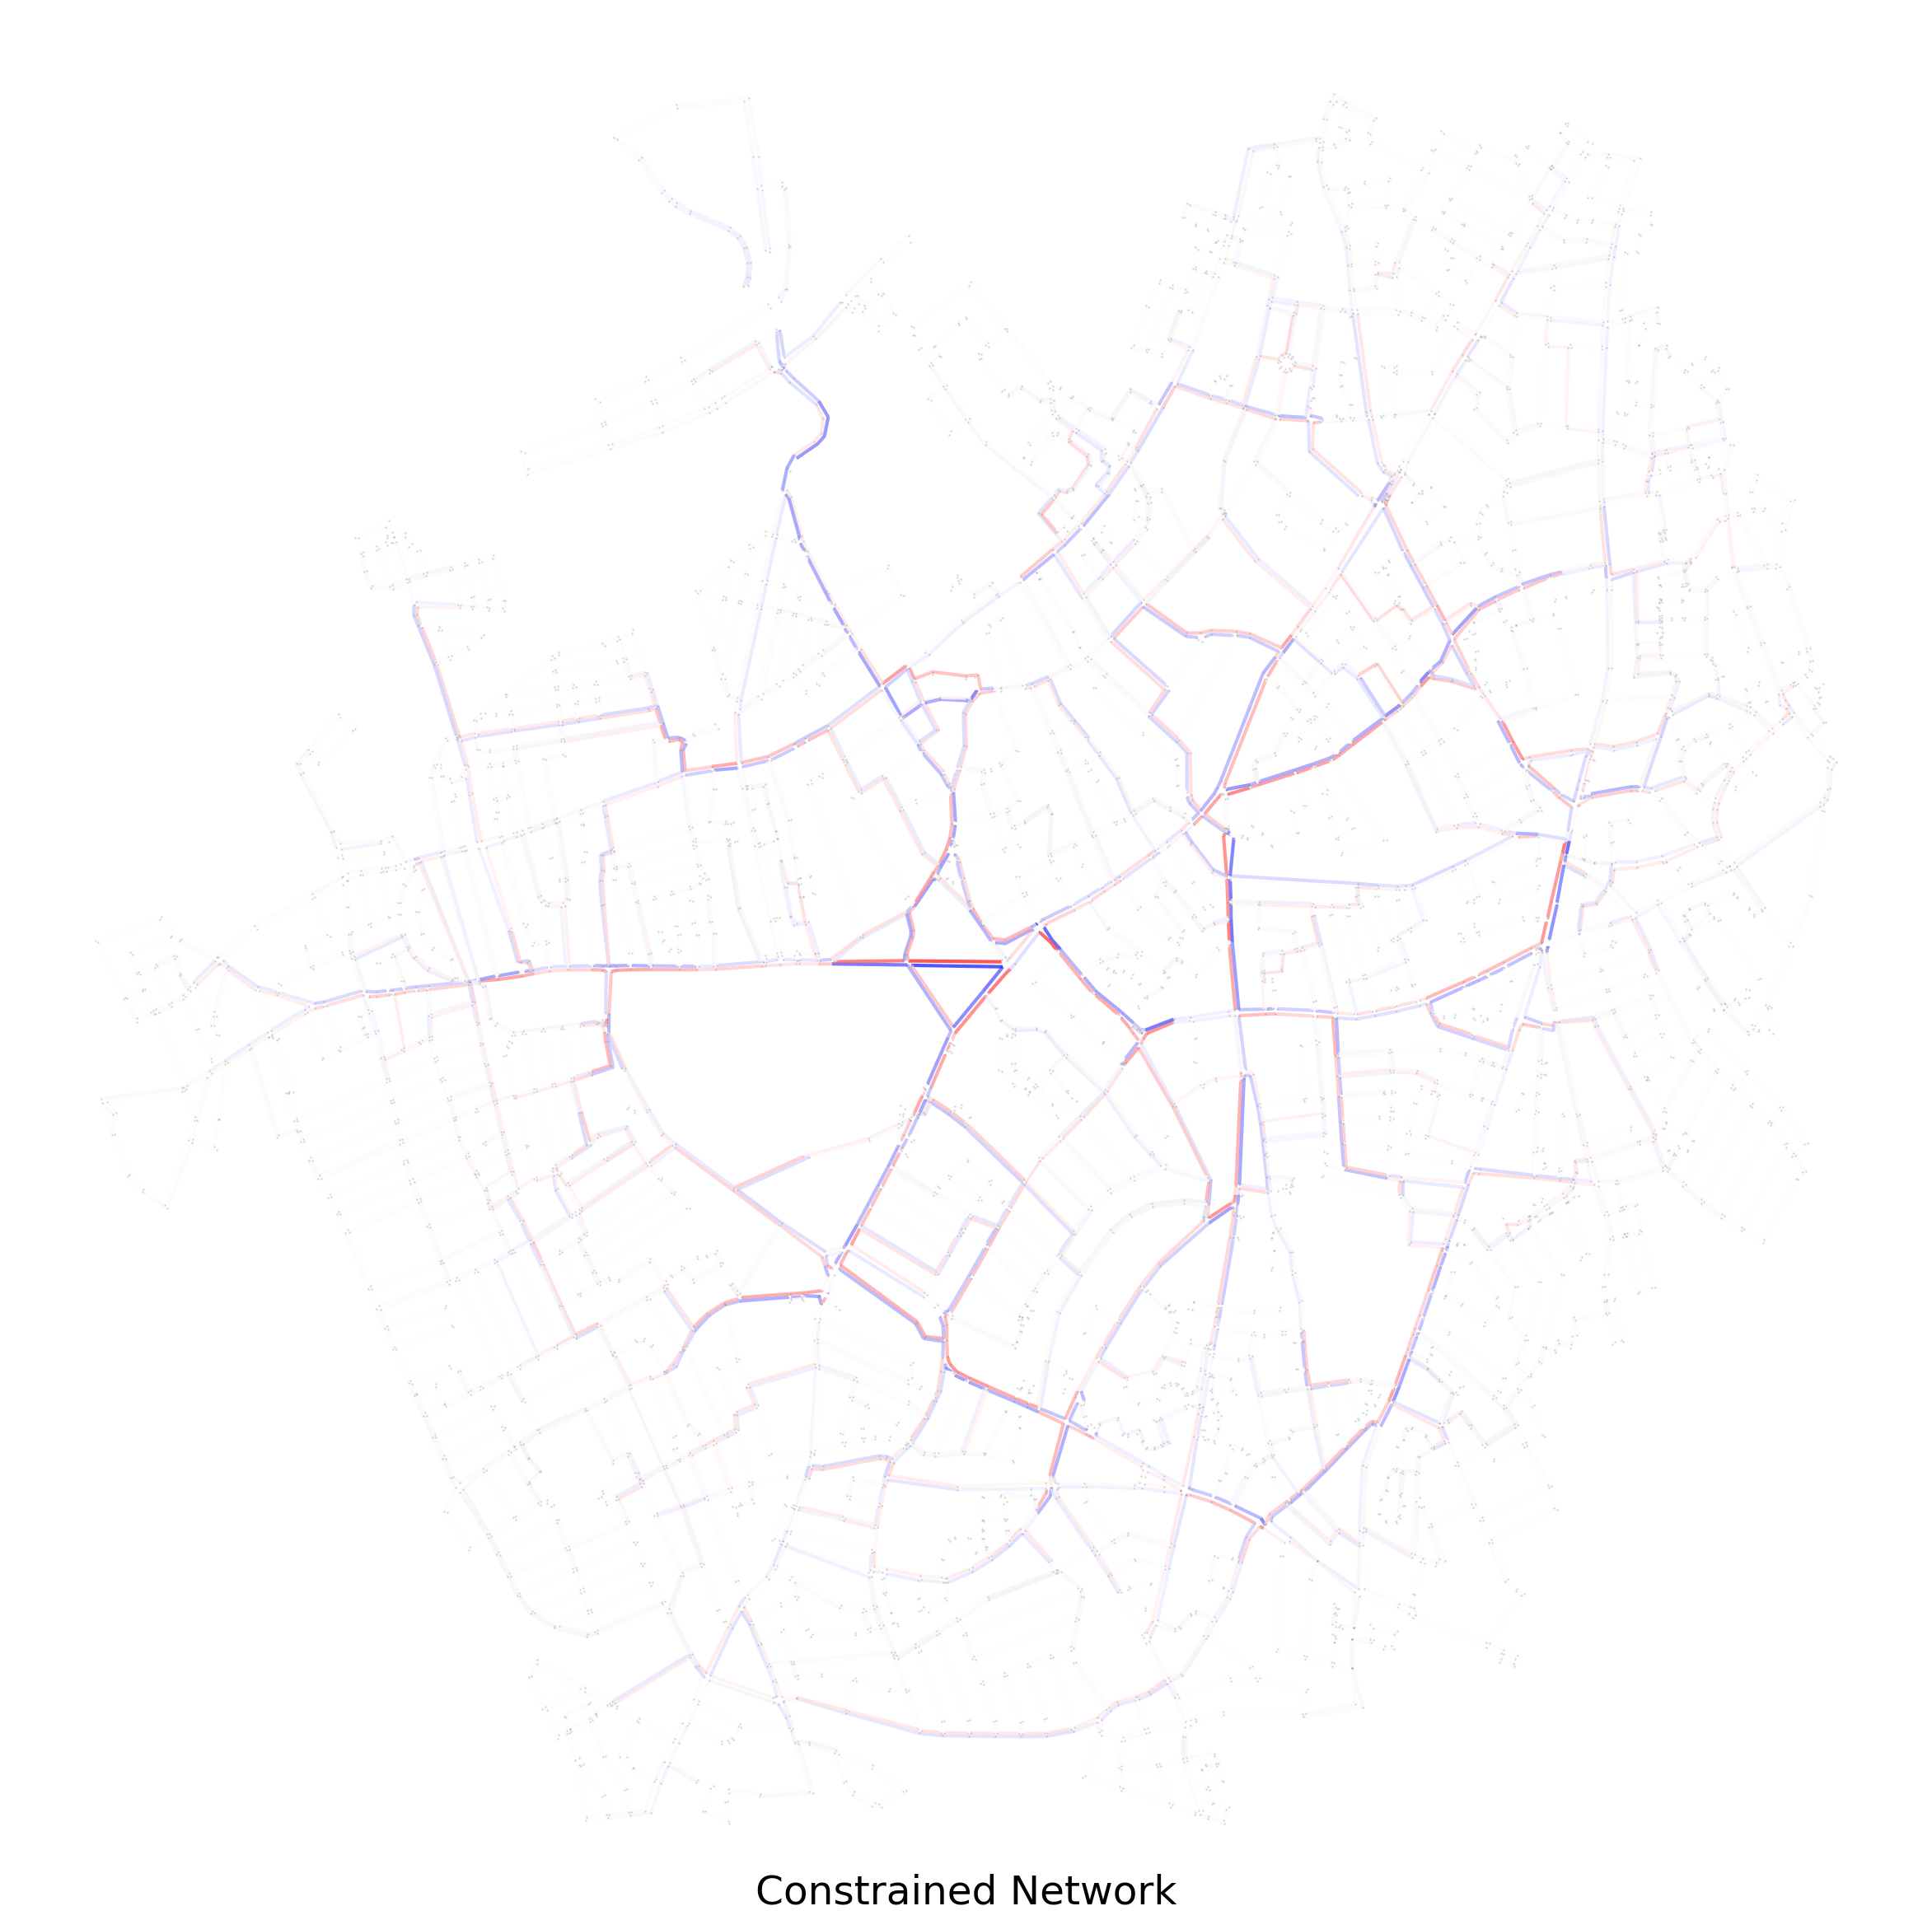

In [28]:
plt.style.use('default')

all_values = np.concatenate([bcdiff_res_data, bcdiff_exdi_data])
vmin = -1*max(abs(all_values))
vmax = max(abs(all_values))


f, ax = plt.subplots(1, 1, figsize = (30,30))
        
road_network_subfigure(ax, G_BCDiffExDi, dict_node_pos, "Constrained Network", edge_color = bcdiff_exdi_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = 0.8, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)

# Add colourbars
smap = plt.cm.ScalarMappable(cmap="bwr", norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(smap, ax=ax, fraction=0.1, shrink = 0.8)
cbar.ax.tick_params(labelsize=25)

# Add inset
axins = f.add_axes([0.6, 0.6, 0.2, 0.2])
road_network_subfigure(axins, G_BCDiffExDi, dict_node_pos, "", edge_color = bcdiff_exdi_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = 0.8, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)
x1, y1, x2, y2 = zoom_bb
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# Set ticks on for insert so it is clearer
axins.axis('on')

_ = f.suptitle("Difference from road segment average pavement link centrality", y = 0.95, fontsize=48, weight = 'bold')

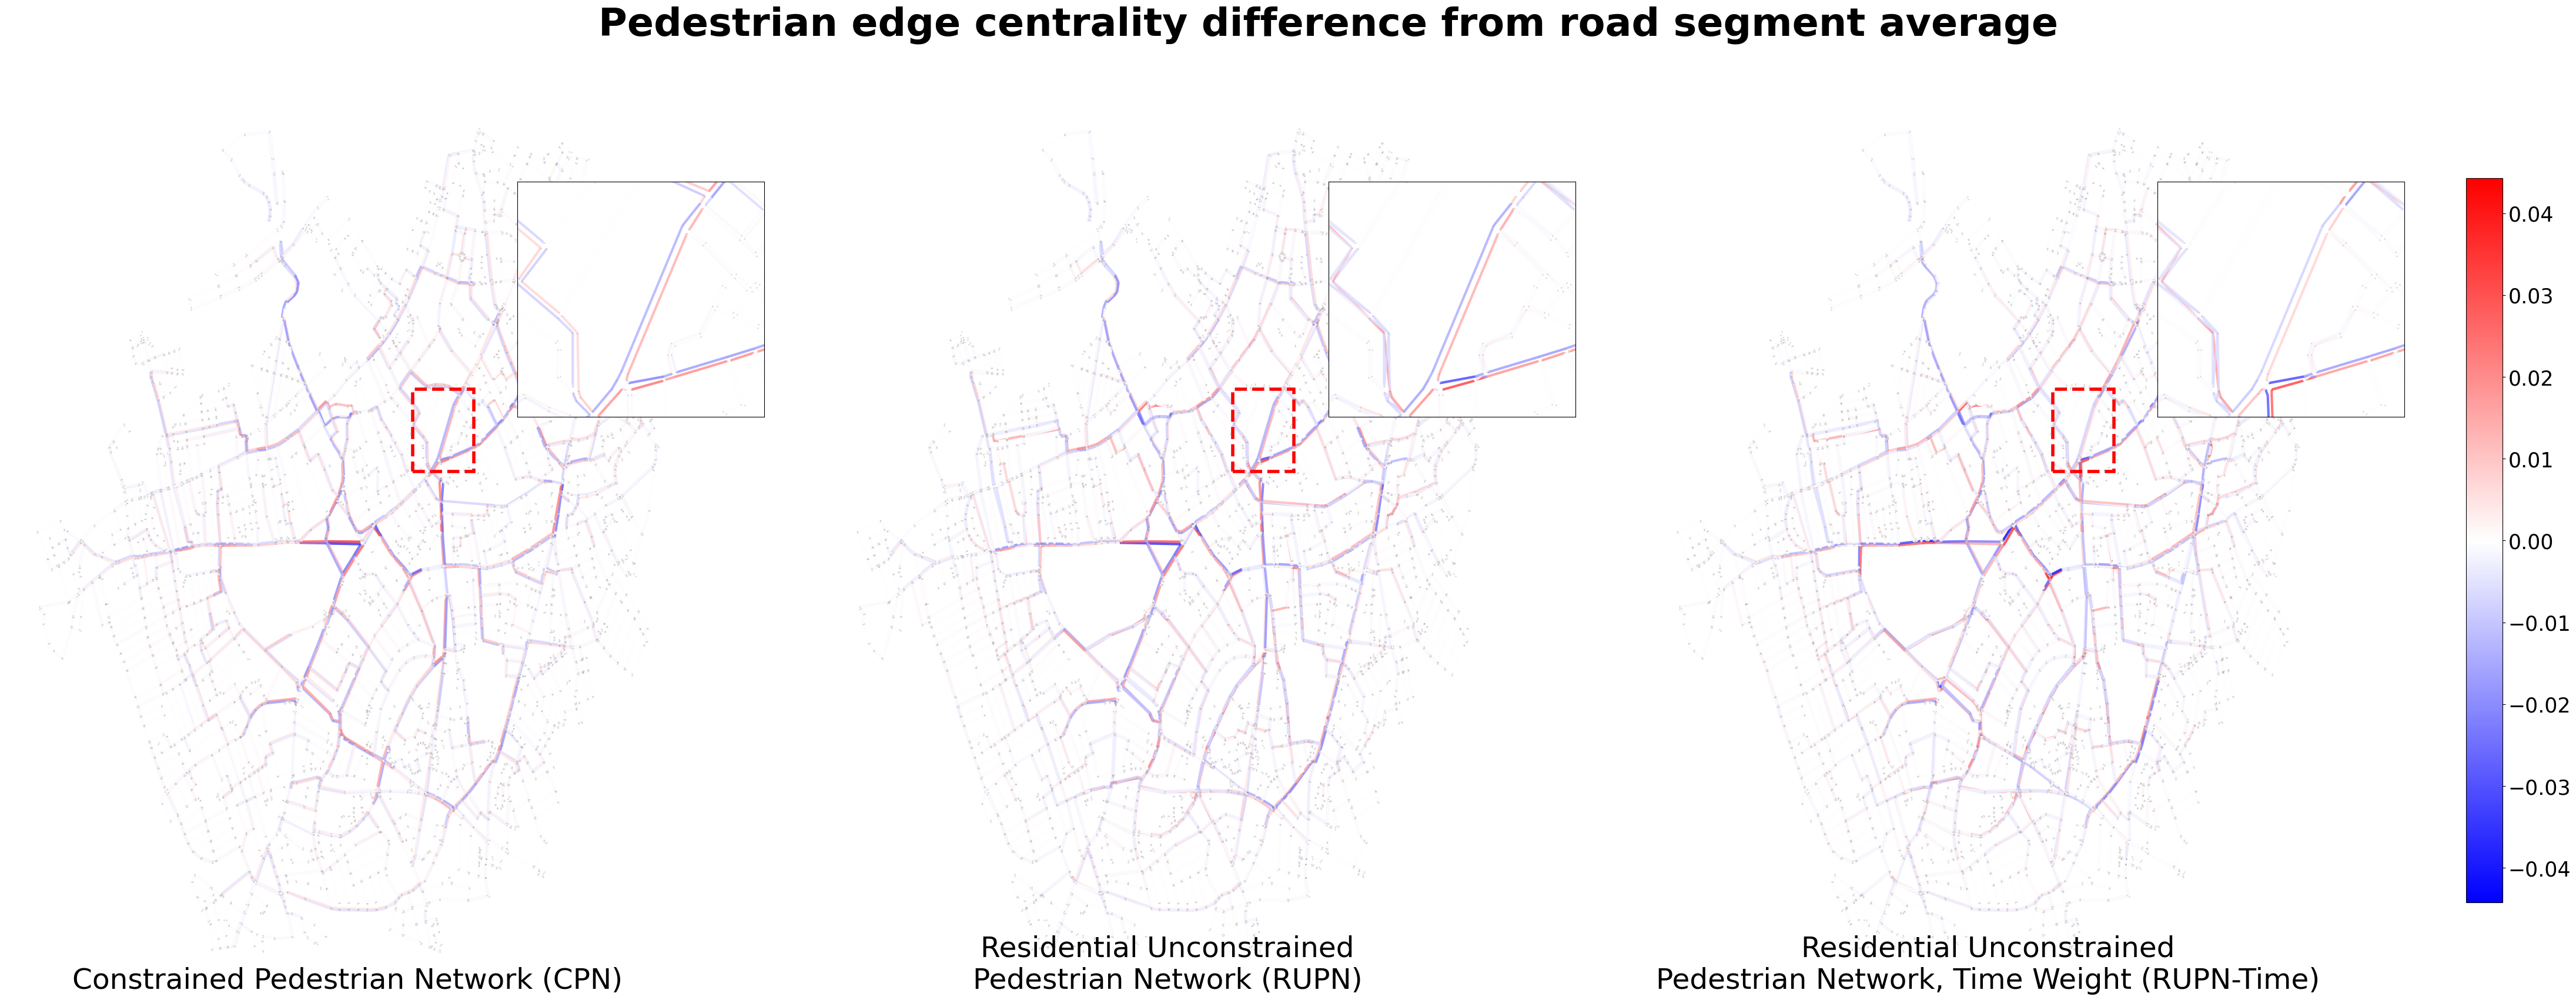

In [33]:
plt.style.use('default')

all_values = np.concatenate([bcdiff_res_data, bcdiff_exdi_data])
vmin = -1*max(abs(all_values))
vmax = max(abs(all_values))


f, axs = plt.subplots(1, 3, figsize = (60,20), sharey=False, sharex=False)
        
road_network_subfigure(axs[0], G_BCDiffExDi, dict_node_pos, "Constrained Pedestrian Network (CPN)", edge_color = bcdiff_exdi_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = 0.8, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)
road_network_subfigure(axs[1], G_BCDiffRes, dict_node_pos, "Residential Unconstrained\nPedestrian Network (RUPN)", edge_color = bcdiff_res_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = 0.8, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)
road_network_subfigure(axs[2], G_BCDiffRT, dict_node_pos, "Residential Unconstrained\nPedestrian Network, Time Weight (RUPN-Time)", edge_color = bcdiff_rt_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = 0.8, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)

# Add rectangles indicating zoom area
x1, y1, x2, y2 = zoom_bb
axs[0].add_patch(Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='red', facecolor='none', lw=4, linestyle='--'))
axs[1].add_patch(Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='red', facecolor='none', lw=4, linestyle='--'))
axs[2].add_patch(Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='red', facecolor='none', lw=4, linestyle='--'))

# Add colourbars
smap = plt.cm.ScalarMappable(cmap="bwr", norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = f.colorbar(smap, ax=axs, fraction=0.1, shrink = 0.8)
cbar.ax.tick_params(labelsize=25)

# Add inset
axins = f.add_axes([0.27, 0.6, 0.07, 0.2])
road_network_subfigure(axins, G_BCDiffExDi, dict_node_pos, "", edge_color = bcdiff_exdi_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = 0.8, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.axis('on')

axins = f.add_axes([0.25*2, 0.6, 0.07, 0.2])
road_network_subfigure(axins, G_BCDiffRes, dict_node_pos, "", edge_color = bcdiff_res_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = 0.8, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.axis('on')

axins = f.add_axes([0.245*3, 0.6, 0.07, 0.2])
road_network_subfigure(axins, G_BCDiffRT, dict_node_pos, "", edge_color = bcdiff_rt_data, edge_cmap = plt.get_cmap('bwr'), edge_width = 2, edge_alpha = 0.8, title_font = {'size': 35}, edge_vmin=vmin, edge_vmax=vmax)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.axis('on')

# Just a single colour bar might be better, requires using same vmin and vmax for both network drawings.

_ = f.suptitle("Pedestrian edge centrality difference from road segment average", y = 0.95, fontsize=48, weight = 'bold')